<a href="https://colab.research.google.com/github/Sercan1111/Cypto-Assets-Ensemble-Learning/blob/main/LSTM_AutoCorrelation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd

# Saatlik dönüştürme fonksiyonu
def resample_to_hourly(df):
    """Dakikalık verileri saatliğe çevirir."""
    df_hourly = df.resample('1H').agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    })
    return df_hourly

# Split işlemi için aynı fonksiyonu kullan
def split_time_series(df):
    """
    Time series verilerini kronolojik olarak böler:
    - Son 3 ay: Test seti (yaklaşık 90 gün)
    - Önceki 3 ay: Validation seti (yaklaşık 90 gün)
    - Geri kalan: Train seti
    """
    test_size = 90 * 24  # Son 3 ay
    val_size = 90 * 24   # Önceki 3 ay

    test_data = df.iloc[-test_size:]
    val_data = df.iloc[-test_size-val_size:-test_size]
    train_data = df.iloc[:-test_size-val_size]

    return train_data, val_data, test_data

# Ana kod başlangıcı
csv_path = '/content/drive/MyDrive/Colab Notebooks/assets.csv'

df = pd.read_csv(csv_path, parse_dates=['timestamp'], index_col='timestamp')
print(f"CSV dosyasından veriler yüklendi: {csv_path}")

# Train/validation/test split işlemi
train_data, val_data, test_data = split_time_series(df)

# Her kripto para için verileri ayır
crypto_folders = ['btc', 'ltc', 'xrp', 'eth']
split_data = {}
for coin in crypto_folders:
    coin_columns = [col for col in df.columns if col.startswith(f'{coin}_')]

    split_data[coin] = {
        'train': train_data[coin_columns].copy(),
        'val': val_data[coin_columns].copy(),
        'test': test_data[coin_columns].copy()
    }


CSV dosyasından veriler yüklendi: /content/drive/MyDrive/Colab Notebooks/assets.csv


In [ ]:
df.head(5)

btc_open  btc_high  btc_low  btc_close   btc_volume  \
timestamp                                                                  
2021-05-01 00:00:00  57798.77  58212.10  57350.0   57905.85  2477.155986   
2021-05-01 01:00:00  57905.85  58549.00  57461.0   58307.00  1977.418181   
2021-05-01 02:00:00  58530.24  58550.00  57856.0   58192.23  1497.424174   
2021-05-01 03:00:00  58025.00  58330.02  57974.0   58254.02  1078.920290   
2021-05-01 04:00:00  58264.21  58324.53  57604.0   58095.00   951.935085   

                     ltc_open  ltc_high  ltc_low  ltc_close    ltc_volume  \
timestamp                                                                   
2021-05-01 00:00:00    270.92    273.86   270.26     271.16  43152.231939   
2021-05-01 01:00:00    271.11    272.94   268.32     271.14  43869.451713   
2021-05-01 02:00:00    270.44    274.59   270.01     272.70  52131.728182   
2021-05-01 03:00:00    273.20    275.17   272.51     274.57  32032.203174   
2021-05-01 04:00:00    274.72    274.84   271.01     272.76  38632.066241   

                     xrp_open  xrp_high  xrp_low  xrp_close    xrp_volume  \
timestamp                                                                   
2021-05-01 00:00:00   1.60069   1.62900   1.5716     1.5771  6.404972e+06   
2021-05-01 01:00:00   1.57870   1.59425   1.5531     1.5902  5.410584e+06   
2021-05-01 02:00:00   1.59389   1.60859   1.5830     1.5967  3.068491e+06   
2021-05-01 03:00:00   1.59710   1.61099   1.5811     1.5930  4.267388e+06   
2021-05-01 04:00:00   1.59430   1.60501   1.5760     1.5882  4.131956e+06   

                        eth_open  eth_high      eth_low  eth_close  \
timestamp                                                            
2021-05-01 00:00:00  2769.900000   2782.27  2759.901431    2773.04   
2021-05-01 01:00:00  2772.790000   2802.36  2752.200000    2800.00   
2021-05-01 02:00:00  2801.170000   2841.82  2794.300000    2826.67   
2021-05-01 03:00:00  2820.639659   2851.76  2819.300000    2842.05   
2021-05-01 04:00:00  2842.850000   2848.80  2827.100000    2846.44   

                       eth_volume  
timestamp                          
2021-05-01 00:00:00  19188.105776  
2021-05-01 01:00:00  16200.705410  
2021-05-01 02:00:00  42843.112434  
2021-05-01 03:00:00  20015.693050  
2021-05-01 04:00:00  12844.610828

In [ ]:
# Negatif değerleri kontrol etmek için fonksiyon
def check_negative_values(data, name):
   print(f"\nChecking for negative values in {name}:")
   negative_counts = data.lt(0).sum()
   negative_cols = negative_counts[negative_counts > 0]

   if not negative_cols.empty:
       print("Columns with negative values:")
       for col, count in negative_cols.items():
           print(f"  Column: {col}, Negative Count: {count}")
   else:
       print("No negative values found.")

# Her bir set için kontroller
for data_type in ['train', 'val', 'test']:
   print(f"\n{'='*50}")
   print(f"{data_type.upper()} Set Analysis")
   print('='*50)

   for crypto in crypto_folders:
       data = split_data[crypto][data_type]

       print(f"\n{crypto.upper()} Data:")
       print(f"\nColumns:")
       print(data.columns.tolist())

       print(f"\nFirst few rows:")
       print(data.head())

       print(f"\nShape: {data.shape}")

       # Negatif değer kontrolü
       check_negative_values(data, f"{crypto.upper()} {data_type} set")

       print(f"\nBasic Statistics:")
       print(data.describe())


TRAIN Set Analysis

BTC Data:

Columns:
['btc_open', 'btc_high', 'btc_low', 'btc_close', 'btc_volume']

First few rows:
                     btc_open  btc_high  btc_low  btc_close   btc_volume
timestamp                                                               
2021-05-01 00:00:00  57798.77  58212.10  57350.0   57905.85  2477.155986
2021-05-01 01:00:00  57905.85  58549.00  57461.0   58307.00  1977.418181
2021-05-01 02:00:00  58530.24  58550.00  57856.0   58192.23  1497.424174
2021-05-01 03:00:00  58025.00  58330.02  57974.0   58254.02  1078.920290
2021-05-01 04:00:00  58264.21  58324.53  57604.0   58095.00   951.935085

Shape: (13968, 5)

Checking for negative values in BTC train set:
No negative values found.

Basic Statistics:
           btc_open      btc_high       btc_low     btc_close    btc_volume
count  13968.000000  13968.000000  13968.000000  13968.000000  13968.000000
mean   36693.879241  36901.515928  36476.360074  36690.544609   1383.916854
std    13286.351838  13352.4

In [ ]:
df.columns

Index(['btc_open', 'btc_high', 'btc_low', 'btc_close', 'btc_volume',
       'ltc_open', 'ltc_high', 'ltc_low', 'ltc_close', 'ltc_volume',
       'xrp_open', 'xrp_high', 'xrp_low', 'xrp_close', 'xrp_volume',
       'eth_open', 'eth_high', 'eth_low', 'eth_close', 'eth_volume'],
      dtype='object')

In [ ]:
def check_missing_values(df, crypto_folders):
    missing_info = {}
    for crypto in crypto_folders:
        crypto_close_column = f'{crypto}_close'  # Zaten coin_close şeklinde
        missing_count = df[crypto_close_column].isnull().sum()
        missing_timestamps = df[df[crypto_close_column].isnull()].index
        missing_info[crypto] = {
            'missing_count': missing_count,
            'missing_timestamps': missing_timestamps
        }
    return missing_info

# Her bir set için eksik değer kontrolü
for data_type in ['train', 'val', 'test']:
    print(f"\nAnalyzing {data_type.upper()} set:")

    # Her set için DataFrame oluştur
    temp_df = pd.DataFrame()
    for crypto in crypto_folders:
        # Direkt olarak coin_close kolonunu al
        temp_df[f'{crypto}_close'] = split_data[crypto][data_type][f'{crypto}_close']

    # Eksik değerleri kontrol et
    missing_info = check_missing_values(temp_df, crypto_folders)

    # Sonuçları yazdır
    for crypto, info in missing_info.items():
        print(f"\nCrypto: {crypto}")
        print(f"Missing values count: {info['missing_count']}")
        print(f"Missing timestamps: {info['missing_timestamps']}")


Analyzing TRAIN set:

Crypto: btc
Missing values count: 0
Missing timestamps: DatetimeIndex([], dtype='datetime64[ns]', name='timestamp', freq=None)

Crypto: ltc
Missing values count: 23
Missing timestamps: DatetimeIndex(['2022-07-19 00:00:00', '2022-07-19 01:00:00',
               '2022-07-19 02:00:00', '2022-07-19 03:00:00',
               '2022-07-19 04:00:00', '2022-07-19 05:00:00',
               '2022-07-19 06:00:00', '2022-07-19 07:00:00',
               '2022-07-19 08:00:00', '2022-07-19 09:00:00',
               '2022-07-19 10:00:00', '2022-07-19 11:00:00',
               '2022-07-19 12:00:00', '2022-07-19 13:00:00',
               '2022-07-19 14:00:00', '2022-07-19 15:00:00',
               '2022-07-19 16:00:00', '2022-07-19 17:00:00',
               '2022-07-19 18:00:00', '2022-07-19 19:00:00',
               '2022-07-19 20:00:00', '2022-07-19 21:00:00',
               '2022-07-19 22:00:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

Crypto: xrp
Mi

In [ ]:
def fill_missing_values(df, method='linear'):
    if method == 'linear':
        return df.interpolate(method='linear')
    elif method == 'ffill':
        return df.ffill()
    elif method == 'bfill':
        return df.bfill()
    else:
        raise ValueError("Invalid fill method. Use 'linear', 'ffill' or 'bfill'.")

threshold = 0.3
# Her set için eksik verileri doldur
for data_type in ['train', 'val', 'test']:
    print(f"\nProcessing {data_type.upper()} set:")

    # Geçici DataFrame oluştur
    temp_df = pd.DataFrame()
    for crypto in crypto_folders:
        temp_df[f'{crypto}_close'] = split_data[crypto][data_type][f'{crypto}_close']  # Kolon adı değişti

    # Eksik veri oranını hesapla
    total_timestamps = len(temp_df)
    missing_info = check_missing_values(temp_df, crypto_folders)
    to_remove = [crypto for crypto, info in missing_info.items()
                if info['missing_count'] / total_timestamps > threshold]

    # Eksik verileri doldur
    for crypto, info in missing_info.items():
        if crypto not in to_remove:
            temp_df[f'{crypto}_close'] = fill_missing_values(temp_df[f'{crypto}_close'], method='linear')

    # Çok eksik verisi olanları çıkar
    temp_df.drop(columns=[f'{crypto}_close' for crypto in to_remove], inplace=True)

    # Her kripto için split_data'yı güncelle
    for crypto in crypto_folders:
        if crypto not in to_remove:
            # Kolon adı değişti
            split_data[crypto][data_type][f'{crypto}_close'] = temp_df[f'{crypto}_close']

    print(f"Removed cryptos: {to_remove}")
    print(f"Remaining data shape: {temp_df.shape}")


Processing TRAIN set:
Removed cryptos: []
Remaining data shape: (13968, 4)

Processing VAL set:
Removed cryptos: []
Remaining data shape: (2160, 4)

Processing TEST set:
Removed cryptos: []
Remaining data shape: (2160, 4)


In [ ]:
# 1. Tüm kripto paraları belirle
all_coins = ['btc', 'ltc', 'xrp', 'eth']

# 2. Teknik göstergeleri ekleme fonksiyonu
def add_technical_indicators(df, coins):
    """
    Tüm coinler için teknik göstergeleri ekler
    """
    new_df = df.copy()
    for coin in coins:
        # Hareketli Ortalamalar - farklı periyotlar kullan
        new_df[f'{coin}_sma'] = new_df[f'{coin}_close'].rolling(window=20, min_periods=20).mean()
        new_df[f'{coin}_ema'] = new_df[f'{coin}_close'].ewm(span=20, adjust=True, min_periods=20).mean()

        # RSI - standart 14 periyot kullan
        delta = new_df[f'{coin}_close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14, min_periods=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14, min_periods=14).mean()
        rs = gain / loss
        new_df[f'{coin}_rsi'] = 100 - (100 / (1 + rs))

        # MACD - standart periyotları kullan ve signal line ekle
        exp1 = new_df[f'{coin}_close'].ewm(span=12, adjust=True).mean()
        exp2 = new_df[f'{coin}_close'].ewm(span=26, adjust=True).mean()
        macd = exp1 - exp2
        signal = macd.ewm(span=9, adjust=True).mean()  # 9 günlük signal line
        new_df[f'{coin}_macd'] = macd
        new_df[f'{coin}_macd_signal'] = signal
        new_df[f'{coin}_macd_hist'] = macd - signal

    return new_df

# 3. Veri işlemi
processed_data = {}
for data_type in ['train', 'val', 'test']:
    temp_df = pd.DataFrame()

    # Tüm coinlerin temel özelliklerini ekle
    for crypto in all_coins:
        for col in ['open', 'high', 'low', 'close', 'volume']:
            temp_df[f'{crypto}_{col}'] = split_data[crypto][data_type][f'{crypto}_{col}']

    # Teknik göstergeleri ekle
    temp_df = add_technical_indicators(temp_df, all_coins)
    processed_data[data_type] = temp_df

In [ ]:
for data_type in ['train', 'val', 'test']:
    print(f"{data_type} columns:")
    print(processed_data[data_type].columns.tolist())


train columns:
['btc_open', 'btc_high', 'btc_low', 'btc_close', 'btc_volume', 'ltc_open', 'ltc_high', 'ltc_low', 'ltc_close', 'ltc_volume', 'xrp_open', 'xrp_high', 'xrp_low', 'xrp_close', 'xrp_volume', 'eth_open', 'eth_high', 'eth_low', 'eth_close', 'eth_volume', 'btc_sma', 'btc_ema', 'btc_rsi', 'btc_macd', 'btc_macd_signal', 'btc_macd_hist', 'ltc_sma', 'ltc_ema', 'ltc_rsi', 'ltc_macd', 'ltc_macd_signal', 'ltc_macd_hist', 'xrp_sma', 'xrp_ema', 'xrp_rsi', 'xrp_macd', 'xrp_macd_signal', 'xrp_macd_hist', 'eth_sma', 'eth_ema', 'eth_rsi', 'eth_macd', 'eth_macd_signal', 'eth_macd_hist']
val columns:
['btc_open', 'btc_high', 'btc_low', 'btc_close', 'btc_volume', 'ltc_open', 'ltc_high', 'ltc_low', 'ltc_close', 'ltc_volume', 'xrp_open', 'xrp_high', 'xrp_low', 'xrp_close', 'xrp_volume', 'eth_open', 'eth_high', 'eth_low', 'eth_close', 'eth_volume', 'btc_sma', 'btc_ema', 'btc_rsi', 'btc_macd', 'btc_macd_signal', 'btc_macd_hist', 'ltc_sma', 'ltc_ema', 'ltc_rsi', 'ltc_macd', 'ltc_macd_signal', 'ltc_

Training set üzerinde autocorrelation analizi yapılıyor...


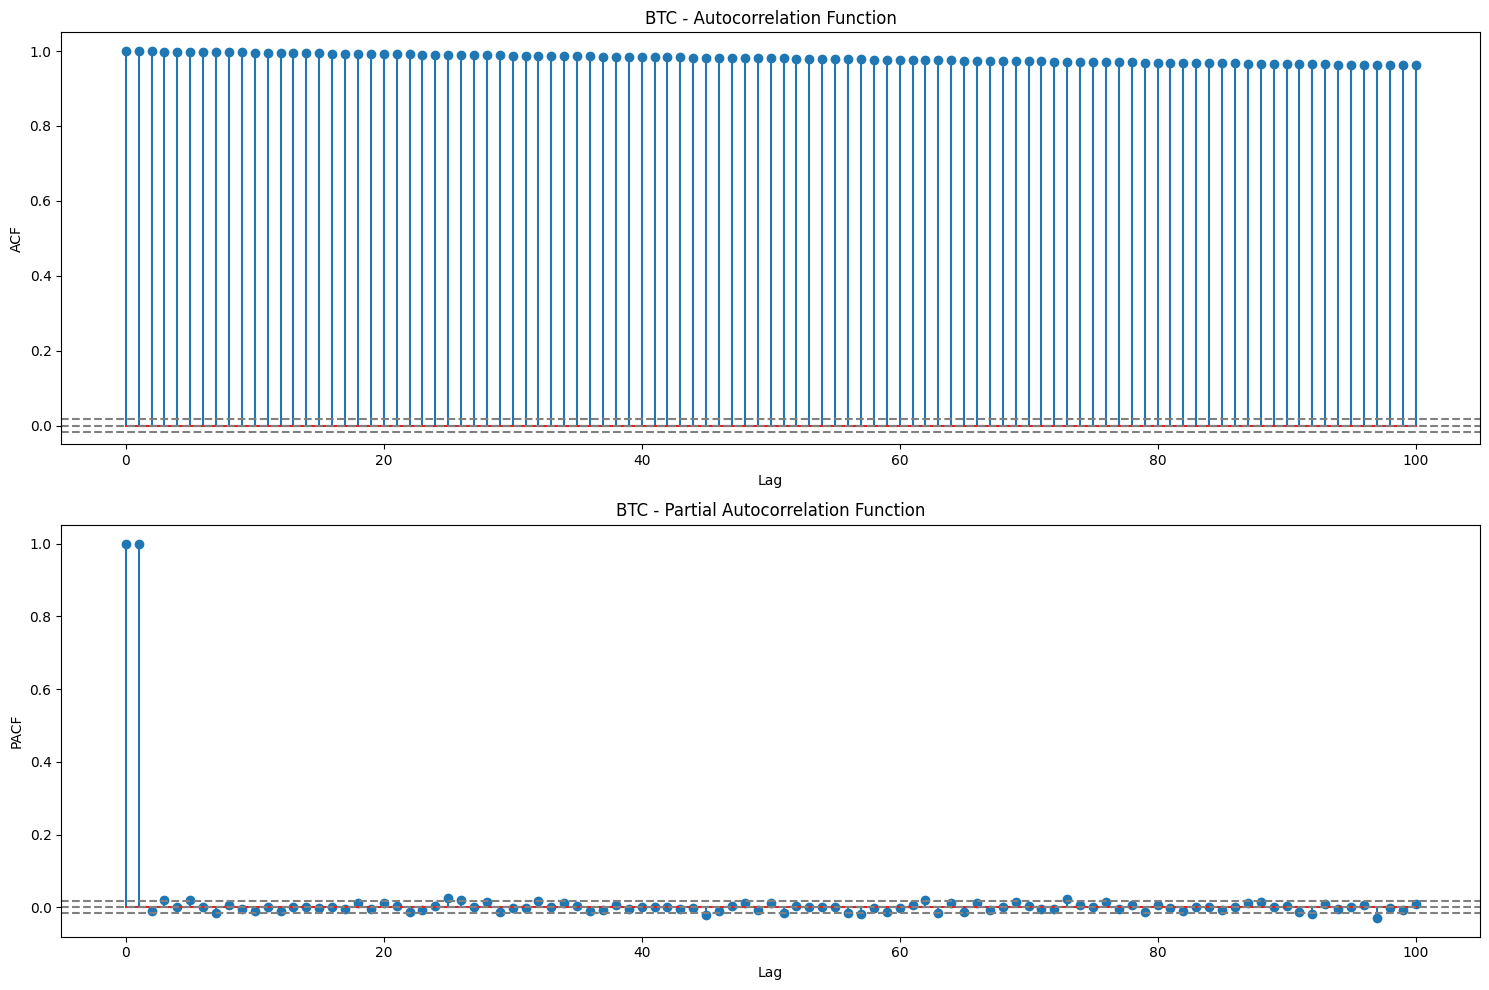


BTC Analysis:
Significant ACF lags: [0 1 2 3 4 5 6 7 8 9]...
Significant PACF lags: [ 0  1  3  5 25 26 32 45 57 62]...


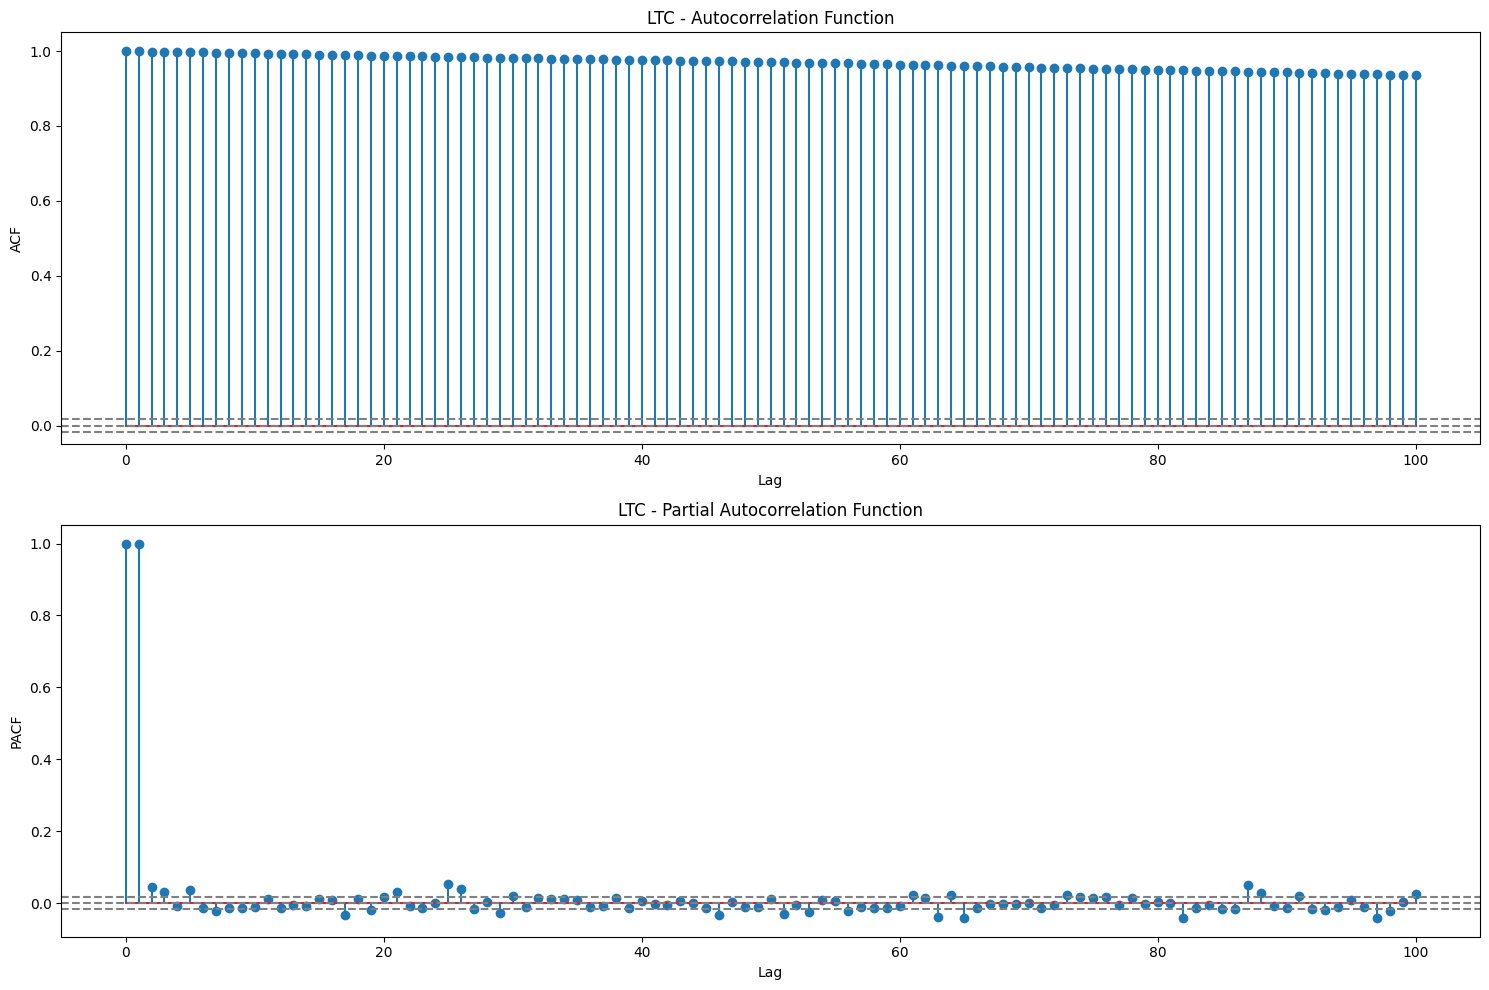


LTC Analysis:
Significant ACF lags: [0 1 2 3 4 5 6 7 8 9]...
Significant PACF lags: [ 0  1  2  3  5  7 17 19 20 21]...


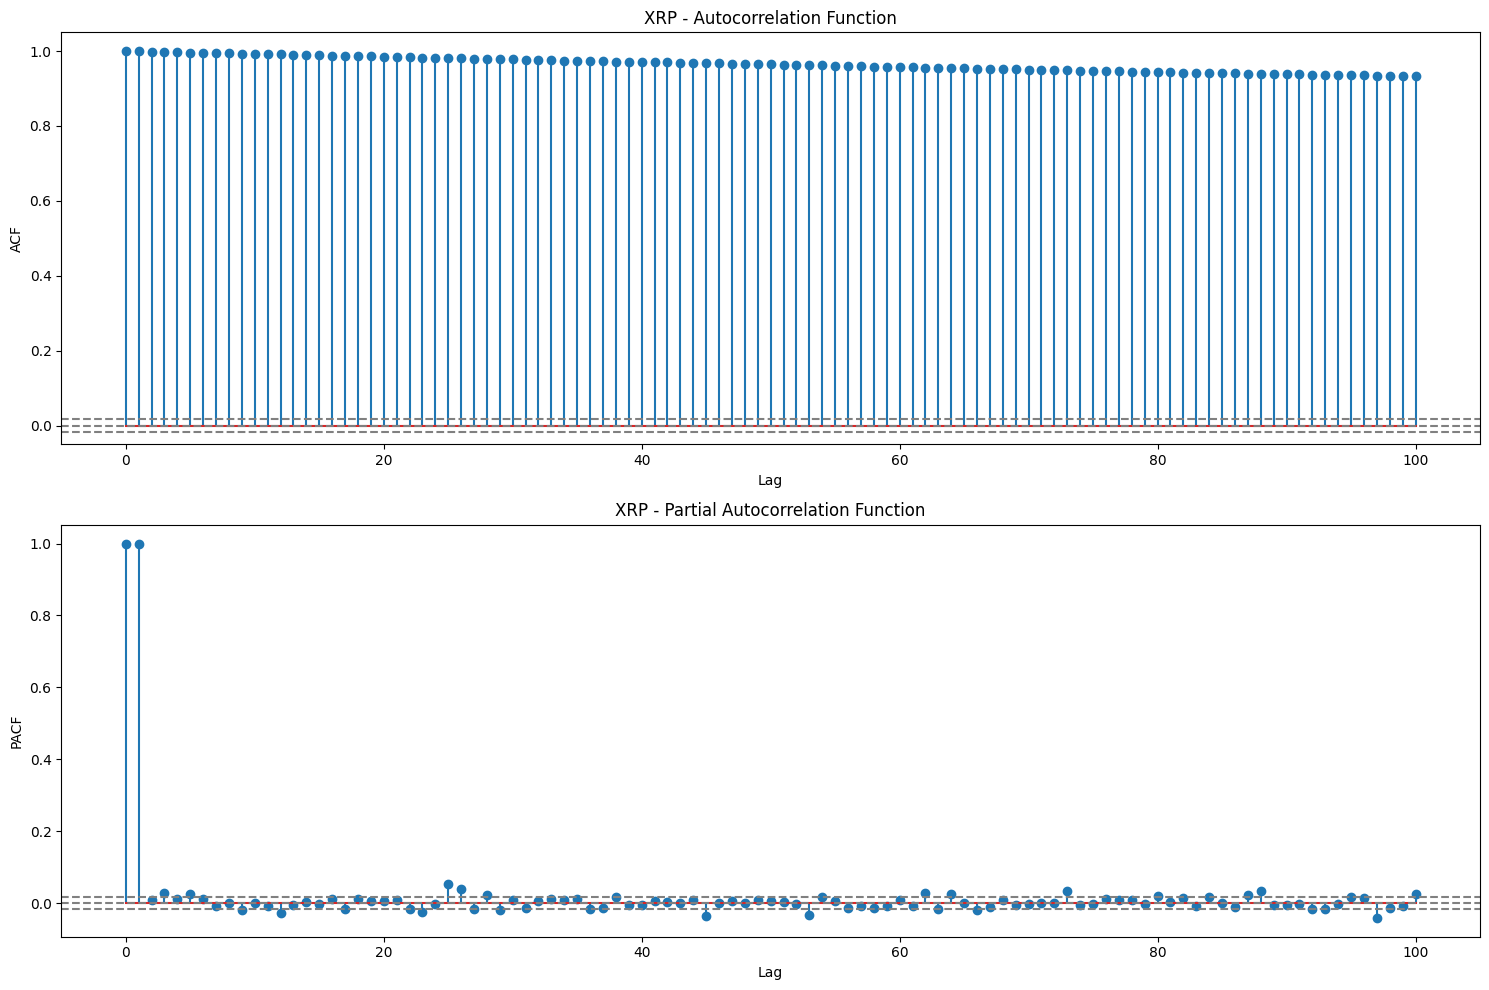


XRP Analysis:
Significant ACF lags: [0 1 2 3 4 5 6 7 8 9]...
Significant PACF lags: [ 0  1  3  5  9 12 17 22 23 25]...


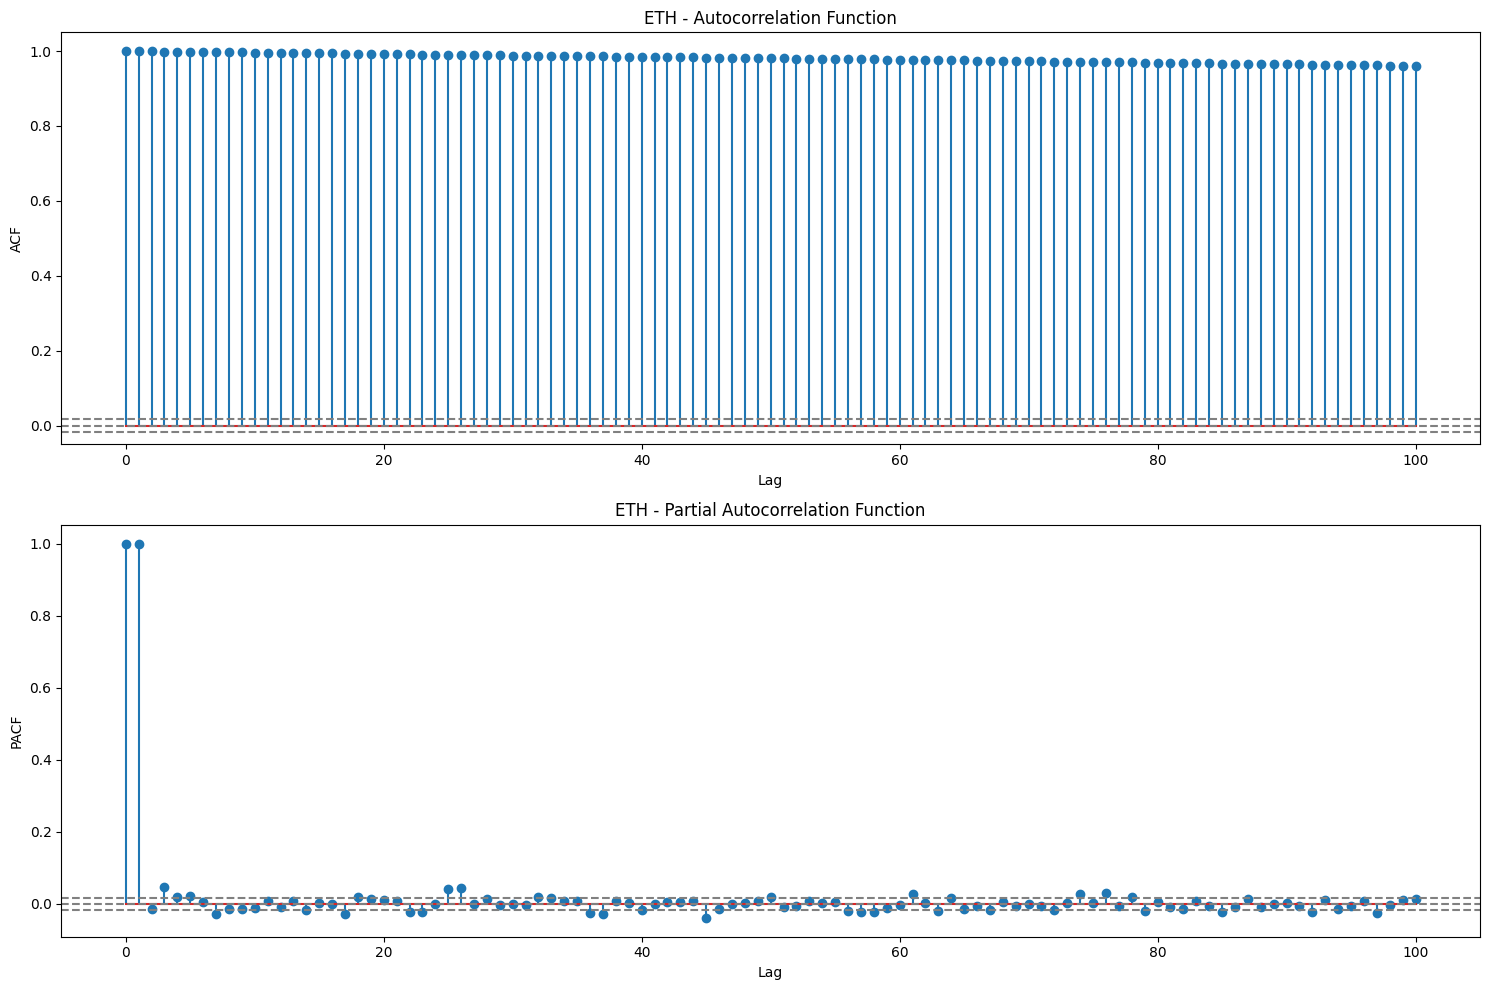


ETH Analysis:
Significant ACF lags: [0 1 2 3 4 5 6 7 8 9]...
Significant PACF lags: [ 0  1  3  4  5  7 17 18 22 23]...

Kriptolar arası cross-correlation analizi yapılıyor...


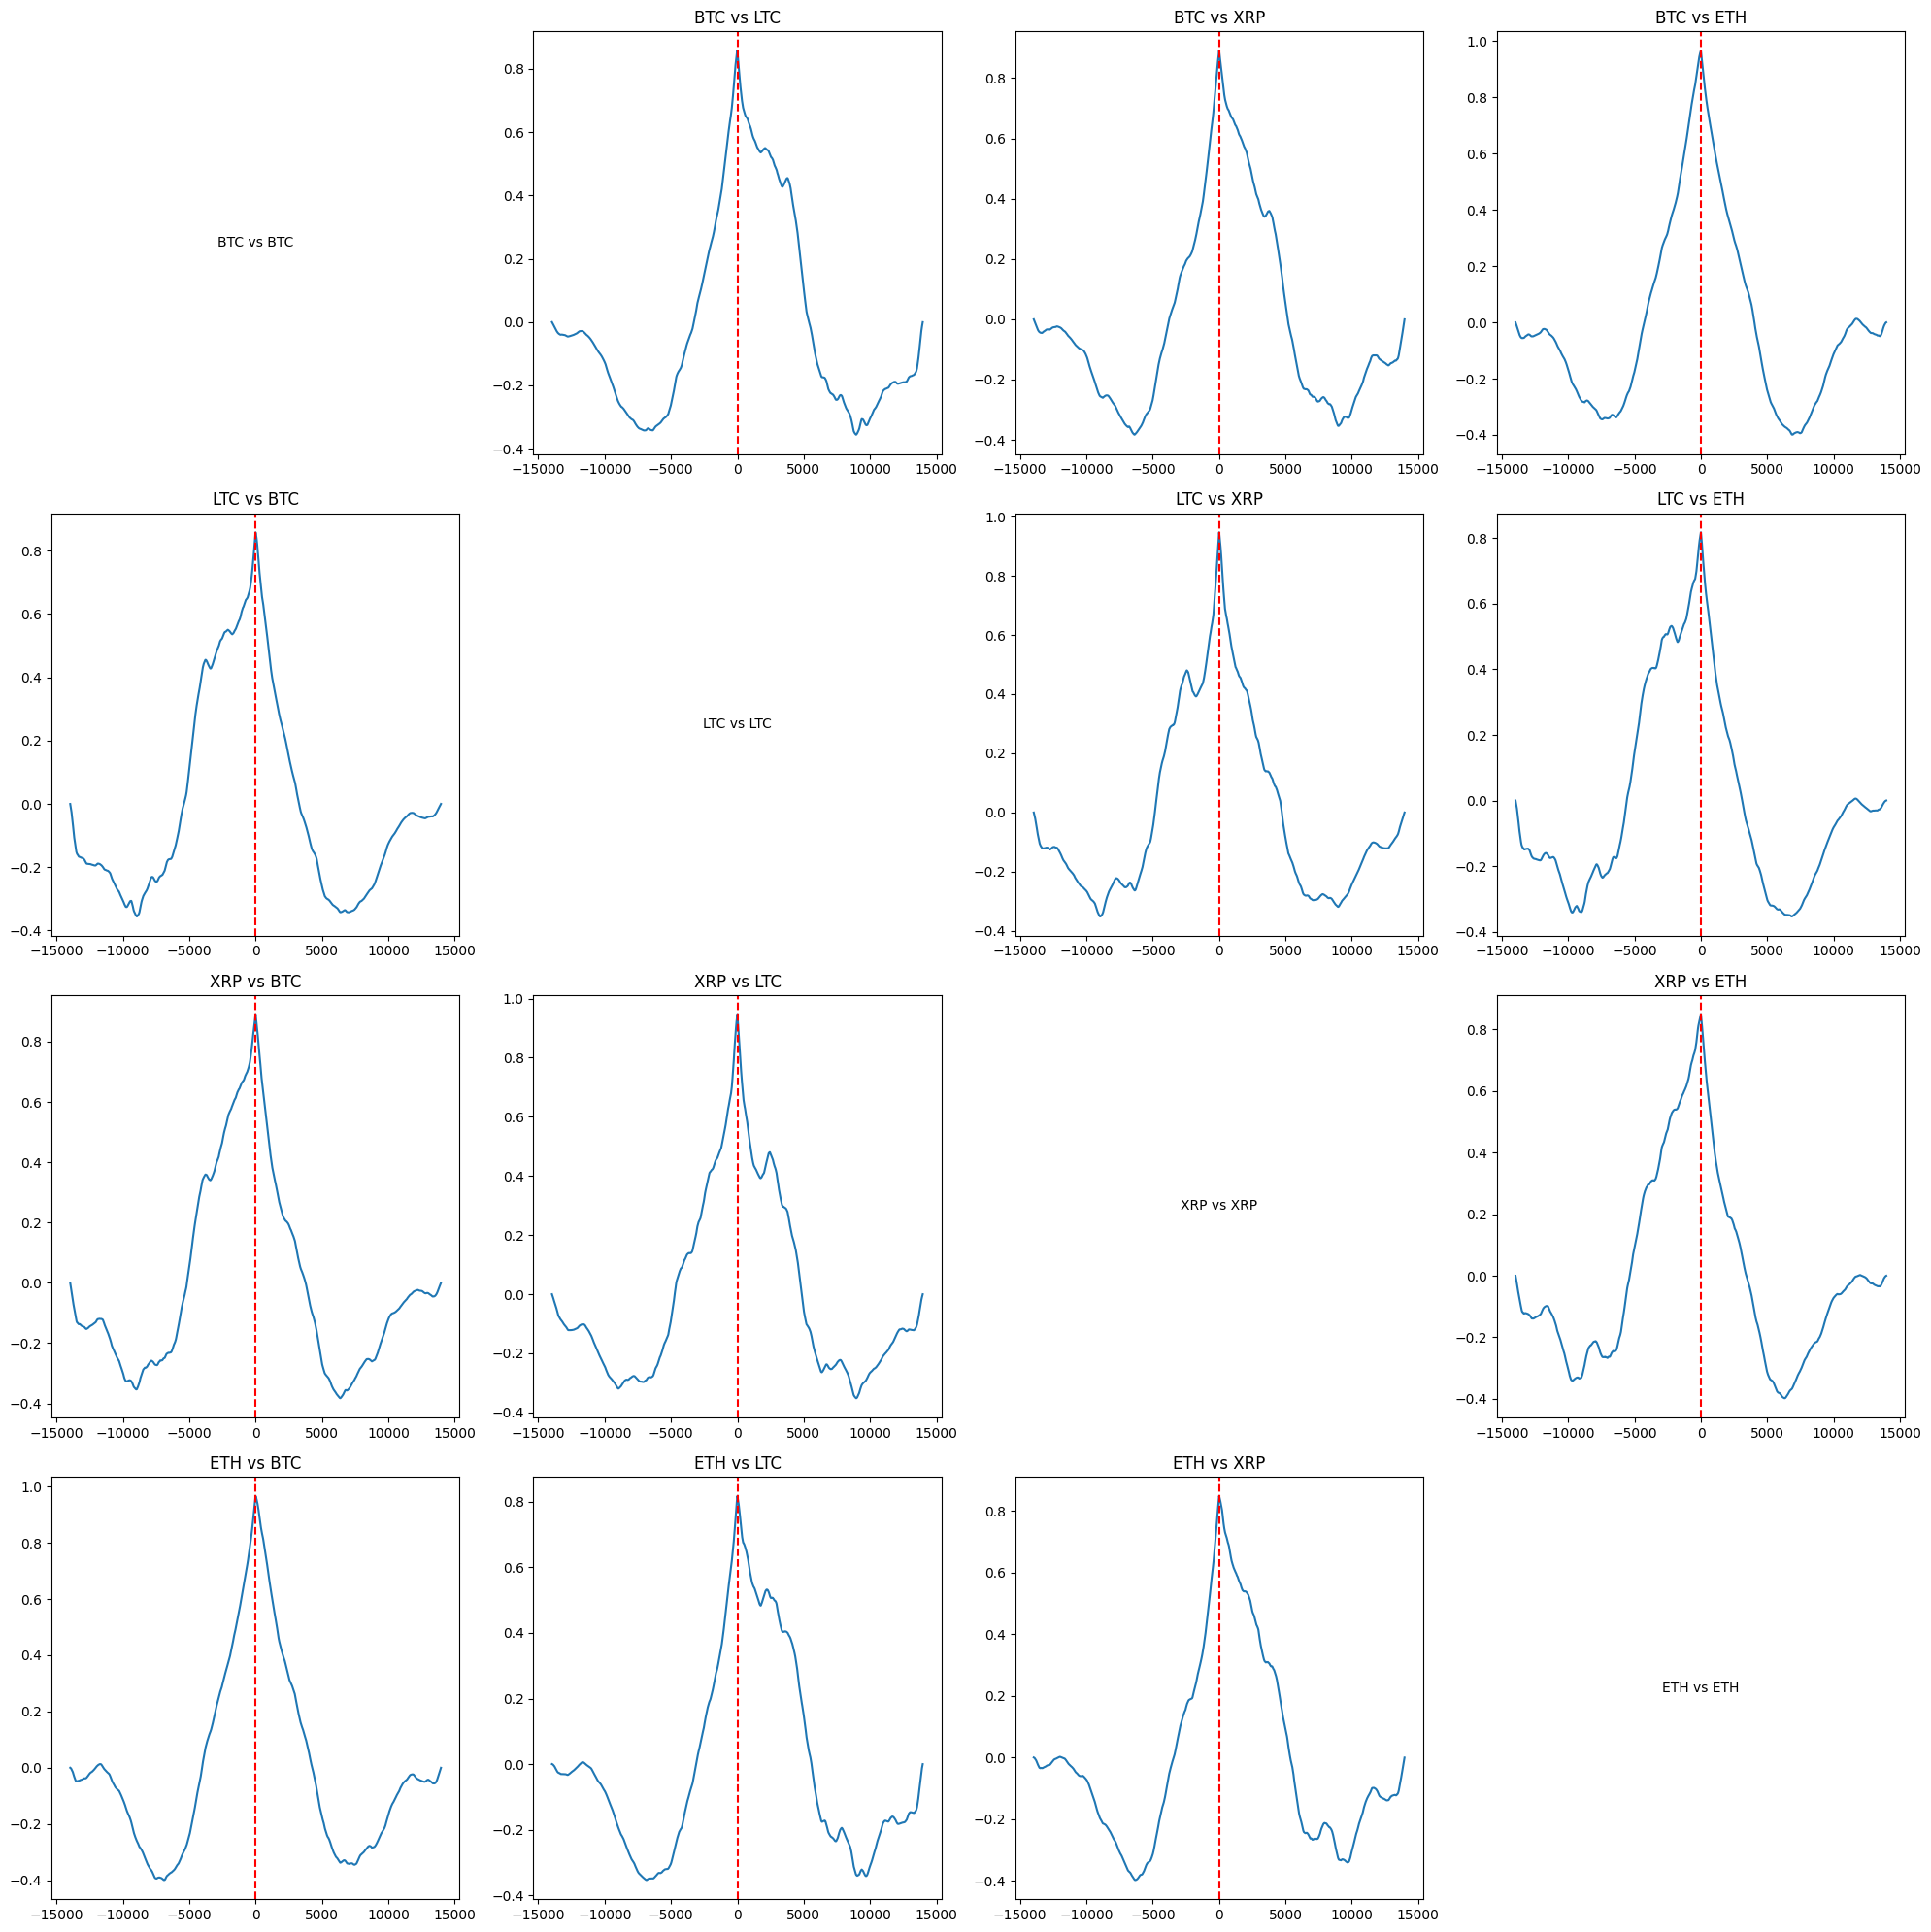

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def analyze_autocorrelation(data, all_coins, max_lags=100):
    """
    Her kripto için ACF ve PACF analizini gerçekleştirir

    Parameters:
    -----------
    data : DataFrame
        İşlenecek veri
    all_coins : list
        Kripto para listesi
    max_lags : int
        Maksimum lag sayısı
    """
    results = {}

    for coin in all_coins:
        # Close price serisini al
        close_series = data[f'{coin}_close']

        # ACF ve PACF hesapla
        acf_values = acf(close_series, nlags=max_lags)
        pacf_values = pacf(close_series, nlags=max_lags)

        # Görselleştirme
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

        # ACF plot
        ax1.stem(range(len(acf_values)), acf_values)
        ax1.axhline(y=0, linestyle='--', color='gray')
        ax1.axhline(y=1.96/np.sqrt(len(close_series)), linestyle='--', color='gray')
        ax1.axhline(y=-1.96/np.sqrt(len(close_series)), linestyle='--', color='gray')
        ax1.set_title(f'{coin.upper()} - Autocorrelation Function')
        ax1.set_xlabel('Lag')
        ax1.set_ylabel('ACF')

        # PACF plot
        ax2.stem(range(len(pacf_values)), pacf_values)
        ax2.axhline(y=0, linestyle='--', color='gray')
        ax2.axhline(y=1.96/np.sqrt(len(close_series)), linestyle='--', color='gray')
        ax2.axhline(y=-1.96/np.sqrt(len(close_series)), linestyle='--', color='gray')
        ax2.set_title(f'{coin.upper()} - Partial Autocorrelation Function')
        ax2.set_xlabel('Lag')
        ax2.set_ylabel('PACF')

        plt.tight_layout()
        plt.show()

        # Significant lag'leri belirle
        confidence_interval = 1.96/np.sqrt(len(close_series))
        significant_acf_lags = np.where(np.abs(acf_values) > confidence_interval)[0]
        significant_pacf_lags = np.where(np.abs(pacf_values) > confidence_interval)[0]

        # Sonuçları kaydet
        results[coin] = {
            'acf_values': acf_values,
            'pacf_values': pacf_values,
            'significant_acf_lags': significant_acf_lags,
            'significant_pacf_lags': significant_pacf_lags
        }

        print(f"\n{coin.upper()} Analysis:")
        print(f"Significant ACF lags: {significant_acf_lags[:10]}...")  # İlk 10 lag
        print(f"Significant PACF lags: {significant_pacf_lags[:10]}...")  # İlk 10 lag

    return results

def analyze_cross_correlation(data, all_coins, max_lags=50):
    """
    Kriptolar arası cross-correlation analizi
    """
    n_coins = len(all_coins)
    fig, axes = plt.subplots(n_coins, n_coins, figsize=(20, 20))

    for i, coin1 in enumerate(all_coins):
        for j, coin2 in enumerate(all_coins):
            if i != j:
                # Cross correlation hesapla
                series1 = data[f'{coin1}_close']
                series2 = data[f'{coin2}_close']

                cross_corr = np.correlate(
                    (series1 - series1.mean()) / series1.std(),
                    (series2 - series2.mean()) / series2.std(),
                    mode='full'
                )

                # Normalize et
                cross_corr = cross_corr / len(series1)

                # Lag değerlerini hesapla
                lags = np.arange(-(len(cross_corr)//2), len(cross_corr)//2 + 1)

                # Plot
                axes[i, j].plot(lags, cross_corr)
                axes[i, j].axvline(x=0, color='r', linestyle='--')
                axes[i, j].set_title(f'{coin1.upper()} vs {coin2.upper()}')
            else:
                axes[i, j].text(0.5, 0.5, f'{coin1.upper()} vs {coin1.upper()}',
                              ha='center', va='center')
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Autocorrelation analizi yap (processed_data oluşturulduktan hemen sonra çalıştır)
print("Training set üzerinde autocorrelation analizi yapılıyor...")
autocorr_results = analyze_autocorrelation(processed_data['train'], all_coins)

# Cross-correlation analizi yap
print("\nKriptolar arası cross-correlation analizi yapılıyor...")
analyze_cross_correlation(processed_data['train'], all_coins)

In [ ]:
def optimize_sequence_length(autocorr_results, all_coins, max_length=24):
    """
    ACF/PACF sonuçlarına göre optimal sequence length belirler

    Parameters:
    -----------
    autocorr_results : dict
        analyze_autocorrelation fonksiyonundan gelen sonuçlar
    all_coins : list
        Kripto para listesi
    max_length : int
        Maksimum sequence length

    Returns:
    --------
    optimal_length : int
        Önerilen sequence length
    """
    significant_lags = {}

    for coin in all_coins:
        # PACF'de anlamlı lag'leri al
        pacf_lags = autocorr_results[coin]['significant_pacf_lags']

        # İlk anlamlı düşüşü bul
        prev_value = abs(autocorr_results[coin]['pacf_values'][0])
        drop_lag = 1

        for i in range(1, len(autocorr_results[coin]['pacf_values'])):
            current_value = abs(autocorr_results[coin]['pacf_values'][i])
            if current_value < 0.2 and prev_value > 0.2:  # 0.2 threshold değeri
                drop_lag = i
                break
            prev_value = current_value

        significant_lags[coin] = drop_lag
        print(f"{coin.upper()} için anlamlı lag sayısı: {drop_lag}")

    # En uzun anlamlı lag'i al ve bir güvenlik marjı ekle
    base_length = max(significant_lags.values())
    optimal_length = min(base_length * 2, max_length)  # 2x güvenlik marjı

    print(f"\nÖnerilen sequence length: {optimal_length}")
    print(f"Bu değer şu kriterlere göre belirlendi:")
    print(f"- En uzun anlamlı lag: {base_length}")
    print(f"- Güvenlik marjı: 2x")
    print(f"- Maksimum izin verilen length: {max_length}")

    return optimal_length

# Kullanımı:
optimal_seq_length = optimize_sequence_length(autocorr_results, all_coins)

BTC için anlamlı lag sayısı: 2
LTC için anlamlı lag sayısı: 2
XRP için anlamlı lag sayısı: 2
ETH için anlamlı lag sayısı: 2

Önerilen sequence length: 4
Bu değer şu kriterlere göre belirlendi:
- En uzun anlamlı lag: 2
- Güvenlik marjı: 2x
- Maksimum izin verilen length: 24


In [ ]:
def analyze_feature_importance(processed_data, all_coins):
    """
    Feature'ların önemini analiz eder ve seçim önerileri sunar

    Parameters:
    -----------
    processed_data : dict
        İşlenmiş veri dictionary'si
    all_coins : list
        Kripto para listesi

    Returns:
    --------
    selected_features : dict
        Her kripto için seçilen özellikler
    """
    # Train setini kullan
    df = processed_data['train'].copy()

    # Her kripto için analiz
    selected_features = {}

    for coin in all_coins:
        print(f"\n{'-'*50}")
        print(f"{coin.upper()} Analizi:")

        # Coin'e ait kolonları seç
        coin_cols = [col for col in df.columns if col.startswith(f'{coin}_')]
        coin_df = df[coin_cols]

        # Korelasyon matrisi
        corr_matrix = coin_df.corr()

        # Yüksek korelasyonlu feature çiftlerini bul
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if abs(corr_matrix.iloc[i, j]) > 0.85:  # threshold
                    pair = (corr_matrix.columns[i], corr_matrix.columns[j])
                    high_corr_pairs.append((pair, corr_matrix.iloc[i, j]))

        # Yüksek korelasyonlu çiftleri göster
        if high_corr_pairs:
            print("\nYüksek Korelasyonlu Feature Çiftleri:")
            for (f1, f2), corr in high_corr_pairs:
                print(f"{f1} - {f2}: {corr:.3f}")

        # Feature selection önerileri
        base_features = [f'{coin}_close', f'{coin}_volume']  # Her zaman tutulacak

        # Technical indicators seçimi
        if f'{coin}_sma' in coin_df.columns and f'{coin}_ema' in coin_df.columns:
            # SMA ve EMA'dan birini seç (EMA tercih edilir)
            technical_features = [f'{coin}_ema', f'{coin}_rsi', f'{coin}_macd']
        else:
            technical_features = [f'{coin}_rsi', f'{coin}_macd']

        # Seçilen feature'ları kaydet
        selected_features[coin] = base_features + technical_features

        print("\nSeçilen Features:")
        for f in selected_features[coin]:
            print(f"- {f}")

        # Target ile korelasyonlar
        target_corr = coin_df.corrwith(coin_df[f'{coin}_close']).sort_values(ascending=False)
        print("\nTarget ile Korelasyonlar:")
        print(target_corr)

    return selected_features

# Kullanımı
selected_features = analyze_feature_importance(processed_data, all_coins)


--------------------------------------------------
BTC Analizi:

Yüksek Korelasyonlu Feature Çiftleri:
btc_open - btc_high: 1.000
btc_open - btc_low: 1.000
btc_open - btc_close: 1.000
btc_open - btc_sma: 0.999
btc_open - btc_ema: 0.999
btc_high - btc_low: 1.000
btc_high - btc_close: 1.000
btc_high - btc_sma: 0.999
btc_high - btc_ema: 0.999
btc_low - btc_close: 1.000
btc_low - btc_sma: 0.998
btc_low - btc_ema: 0.999
btc_close - btc_sma: 0.999
btc_close - btc_ema: 0.999
btc_sma - btc_ema: 1.000
btc_macd - btc_macd_signal: 0.953

Seçilen Features:
- btc_close
- btc_volume
- btc_ema
- btc_rsi
- btc_macd

Target ile Korelasyonlar:
btc_close          1.000000
btc_high           0.999850
btc_low            0.999792
btc_open           0.999753
btc_ema            0.998929
btc_sma            0.998519
btc_rsi            0.073103
btc_macd_signal    0.066620
btc_macd           0.063303
btc_macd_hist      0.002173
btc_volume        -0.110387
dtype: float64

-----------------------------------------

ACF (Autocorrelation Function) Analizi:


BTC için ACF grafiğine baktığımızda, tüm lag'lerde yüksek korelasyon görüyoruz (neredeyse 1'e yakın)
Bu durum, serinin çok güçlü bir trend içerdiğini gösteriyor
Confidence interval bandının (kesikli çizgiler) çok üstünde değerler var


PACF (Partial Autocorrelation Function) Analizi:


İlk 1-2 lag'de çok yüksek korelasyon (yaklaşık 1)
Sonrasında değerler hızla düşüyor ve önemsiz hale geliyor
Bu durum, aslında ilk 1-2 lag'in en önemli bilgiyi taşıdığını gösteriyor


Cross-Correlation Analizi:


Tüm kripto çiftleri arasında güçlü pozitif korelasyon var
Özellikle BTC-ETH arasındaki korelasyon dikkat çekici
Lag=0'da maksimum korelasyon görülüyor (yani anlık hareket ediyorlar)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

def scale_features_final(processed_data, all_coins):
    """
    Her coin için ayrı ayrı ve her set için ayrı scaling uygular.
    İndikatörler için özel işlemler içerir.
    """
    scaled_data = {
        'train': pd.DataFrame(),
        'val': pd.DataFrame(),
        'test': pd.DataFrame()
    }

    features = ['open', 'high', 'low', 'close', 'volume', 'sma', 'ema', 'rsi', 'macd']

    # Her coin için ayrı işlem
    for coin in all_coins:
        print(f"\nProcessing {coin.upper()}...")

        # Her feature için ayrı işlem
        for feature in features:
            col_name = f"{coin}_{feature}"
            if col_name not in processed_data['train'].columns:
                continue

            # Her set için ayrı scaler ve işlem
            for data_type in ['train', 'val', 'test']:
                data = processed_data[data_type][col_name].copy()

                # Null değerleri doldur
                if data.isnull().any():
                    if feature == 'sma':
                        # SMA için EMA değerlerini kullan
                        ema_col = f"{coin}_ema"
                        if ema_col in processed_data[data_type].columns:
                            data.fillna(processed_data[data_type][ema_col], inplace=True)
                    elif feature == 'rsi':
                        # RSI için 50 (nötr değer)
                        data.fillna(50, inplace=True)

                # İndikatörlere özel scaling
                if feature == 'macd':
                    # MACD için -1 ile 1 arasına normalize et
                    max_abs = abs(data).max()
                    if max_abs != 0:
                        scaled_values = data / max_abs
                    else:
                        scaled_values = data

                elif feature == 'rsi':
                    # RSI için 0-1 arasına dönüştür
                    scaled_values = data / 100.0

                elif feature == 'volume':
                    # Volume için log-transform ve sonra scaling
                    data = np.log1p(data)
                    scaler = MinMaxScaler(feature_range=(0, 1))
                    scaled_values = scaler.fit_transform(data.values.reshape(-1, 1)).ravel()

                else:
                    # Diğer özellikler için normal MinMaxScaler
                    scaler = MinMaxScaler(feature_range=(0, 1))
                    scaled_values = scaler.fit_transform(data.values.reshape(-1, 1)).ravel()

                scaled_data[data_type][col_name] = scaled_values

                # Range kontrolü ve raporlama
                if not np.isnan(scaled_values).any():
                    print(f"{data_type} {col_name} - Range: [{scaled_values.min():.4f}, {scaled_values.max():.4f}]")

    # Index'leri kopyala
    for data_type in ['train', 'val', 'test']:
        scaled_data[data_type].index = processed_data[data_type].index

    return scaled_data

def verify_scaling_final(scaled_data):
    """
    Scaling sonuçlarını doğrula
    """
    for data_type in ['train', 'val', 'test']:
        print(f"\n{'='*50}")
        print(f"Checking {data_type.upper()} set:")
        print('='*50)
        df = scaled_data[data_type]

        # Her kolon için detaylı kontrol
        for col in df.columns:
            data = df[col].dropna()  # NaN olmayan değerleri al

            if len(data) > 0:  # Eğer veri varsa
                stats = {
                    'min': data.min(),
                    'max': data.max(),
                    'null_count': df[col].isnull().sum(),
                    'outside_range': ((data < -1) | (data > 1)).sum()
                }

                if (stats['min'] < -1 or stats['max'] > 1 or
                    stats['null_count'] > 0 or stats['outside_range'] > 0):
                    print(f"\nColumn: {col}")
                    print(f"Range: [{stats['min']:.4f}, {stats['max']:.4f}]")
                    print(f"Null values: {stats['null_count']}")
                    print(f"Values outside [-1,1]: {stats['outside_range']}")

# Kullanım
scaled_data_final = scale_features_final(processed_data, all_coins)
verify_scaling_final(scaled_data_final)


Processing BTC...
train btc_open - Range: [0.0000, 1.0000]
val btc_open - Range: [0.0000, 1.0000]
test btc_open - Range: [0.0000, 1.0000]
train btc_high - Range: [0.0000, 1.0000]
val btc_high - Range: [0.0000, 1.0000]
test btc_high - Range: [0.0000, 1.0000]
train btc_low - Range: [0.0000, 1.0000]
val btc_low - Range: [0.0000, 1.0000]
test btc_low - Range: [0.0000, 1.0000]
train btc_close - Range: [0.0000, 1.0000]
val btc_close - Range: [0.0000, 1.0000]
test btc_close - Range: [0.0000, 1.0000]
train btc_volume - Range: [0.0000, 1.0000]
val btc_volume - Range: [0.0000, 1.0000]
test btc_volume - Range: [0.0000, 1.0000]
train btc_rsi - Range: [0.0031, 0.9636]
val btc_rsi - Range: [0.0907, 0.9784]
test btc_rsi - Range: [0.0553, 0.9272]
train btc_macd - Range: [-1.0000, 0.5405]
val btc_macd - Range: [-0.4524, 1.0000]
test btc_macd - Range: [-0.6379, 1.0000]

Processing LTC...
val ltc_open - Range: [0.0000, 1.0000]
test ltc_open - Range: [0.0000, 1.0000]
val ltc_high - Range: [0.0000, 1.0000

In [ ]:
def check_indicators_for_issues(processed_data):
    """
    İndikatörlerin oluşturduğu değerleri kontrol eder
    """
    for data_type in ['train', 'val', 'test']:
        print(f"\n{'='*50}")
        print(f"{data_type.upper()} Set Indicator Analysis")
        print('='*50)

        df = processed_data[data_type]

        # İndikatörlerin olduğu kolonları seç
        indicator_cols = [col for col in df.columns if any(ind in col for ind in ['sma', 'ema', 'rsi', 'macd'])]

        for col in indicator_cols:
            stats = {
                'negative_count': (df[col] < 0).sum(),
                'min': df[col].min(),
                'max': df[col].max(),
                'null_count': df[col].isnull().sum()
            }

            print(f"\nColumn: {col}")
            print(f"Negative values: {stats['negative_count']}")
            print(f"Range: [{stats['min']:.4f}, {stats['max']:.4f}]")
            print(f"Null values: {stats['null_count']}")

# Kullanım
check_indicators_for_issues(processed_data)


TRAIN Set Indicator Analysis

Column: btc_sma
Negative values: 0
Range: [15777.7075, 67657.0070]
Null values: 19

Column: btc_ema
Negative values: 0
Range: [15817.6466, 67447.7108]
Null values: 19

Column: btc_rsi
Negative values: 0
Range: [0.3139, 96.3610]
Null values: 13

Column: btc_macd
Negative values: 7324
Range: [-2343.3845, 1266.5860]
Null values: 0

Column: btc_macd_signal
Negative values: 7397
Range: [-2060.9318, 1142.6813]
Null values: 0

Column: btc_macd_hist
Negative values: 7084
Range: [-687.3174, 471.7879]
Null values: 0

Column: ltc_sma
Negative values: 0
Range: [42.9619, 395.0620]
Null values: 19

Column: ltc_ema
Negative values: 0
Range: [43.5441, 388.5692]
Null values: 19

Column: ltc_rsi
Negative values: 0
Range: [0.0000, 99.8934]
Null values: 13

Column: ltc_macd
Negative values: 6994
Range: [-23.9591, 14.4713]
Null values: 0

Column: ltc_macd_signal
Negative values: 7005
Range: [-22.2522, 12.3743]
Null values: 0

Column: ltc_macd_hist
Negative values: 6887
Range:

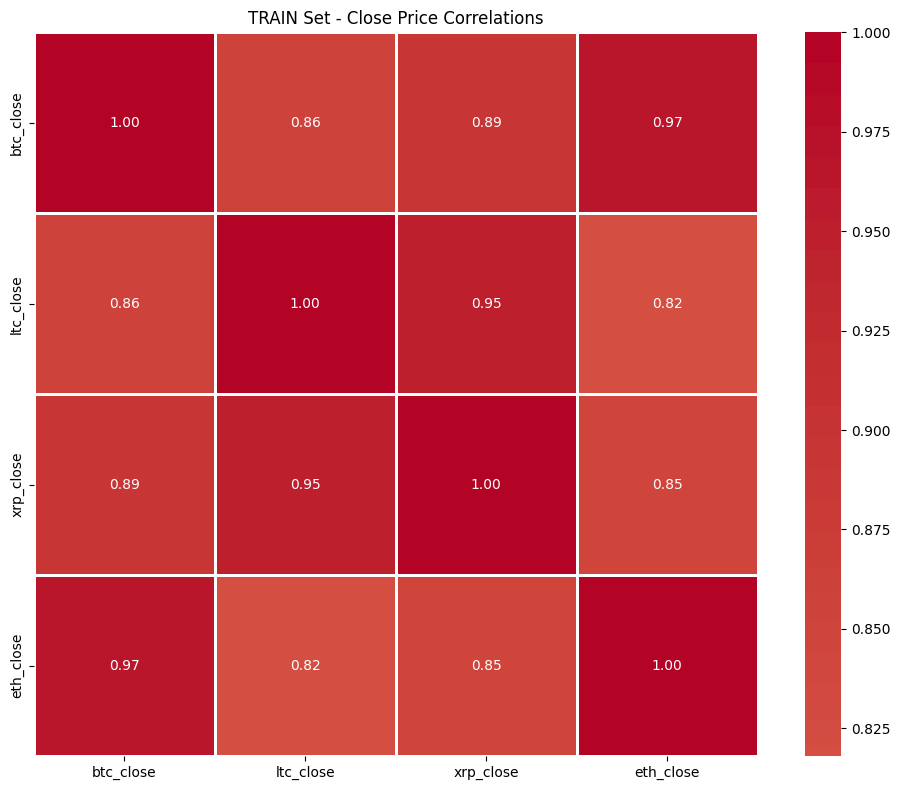

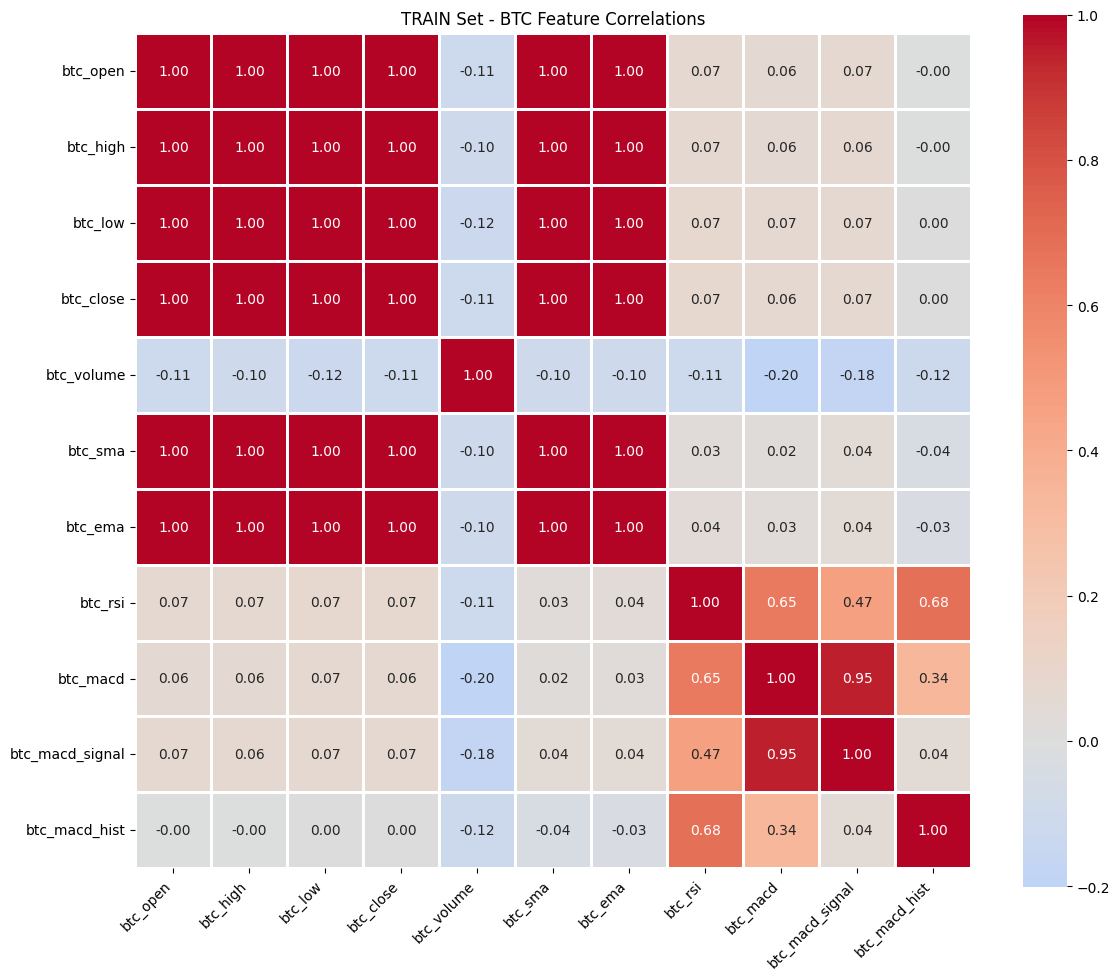

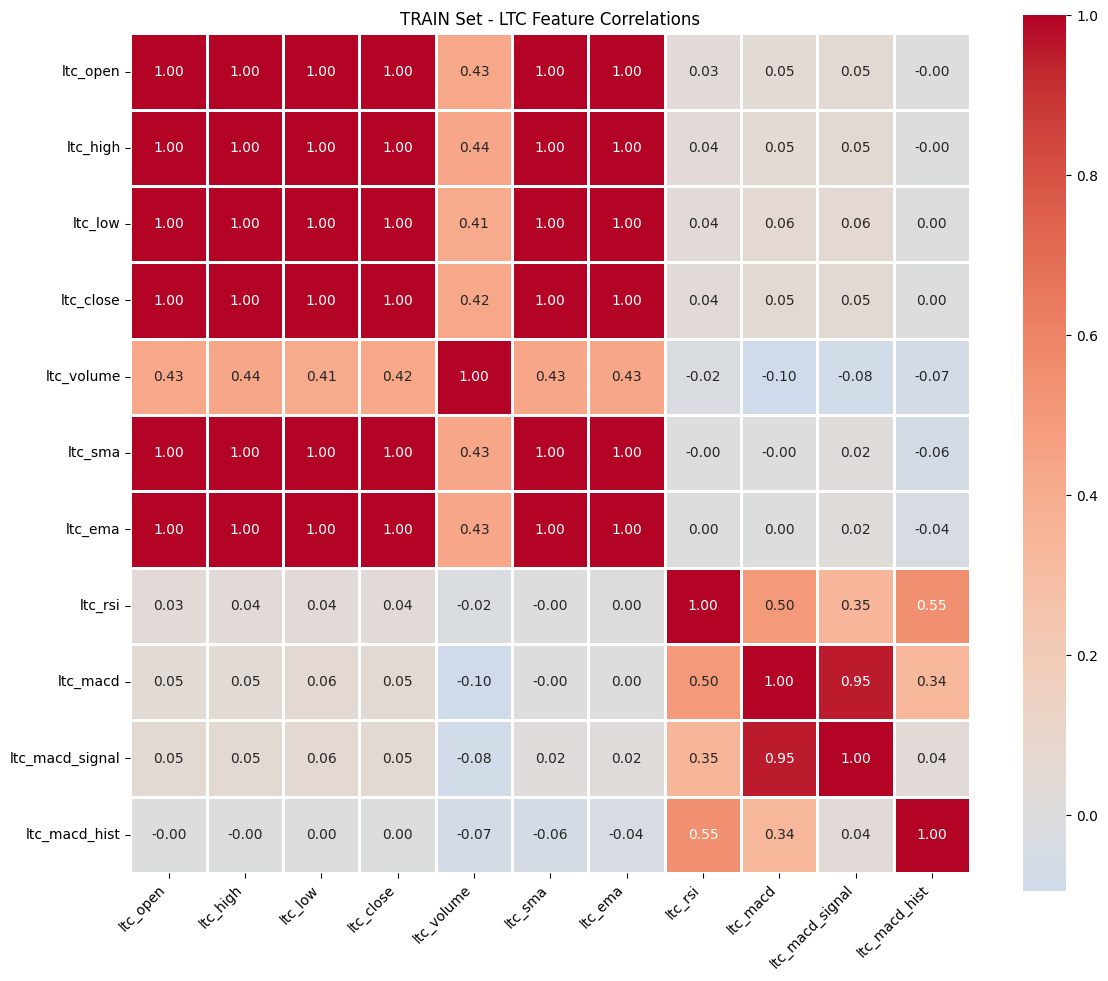

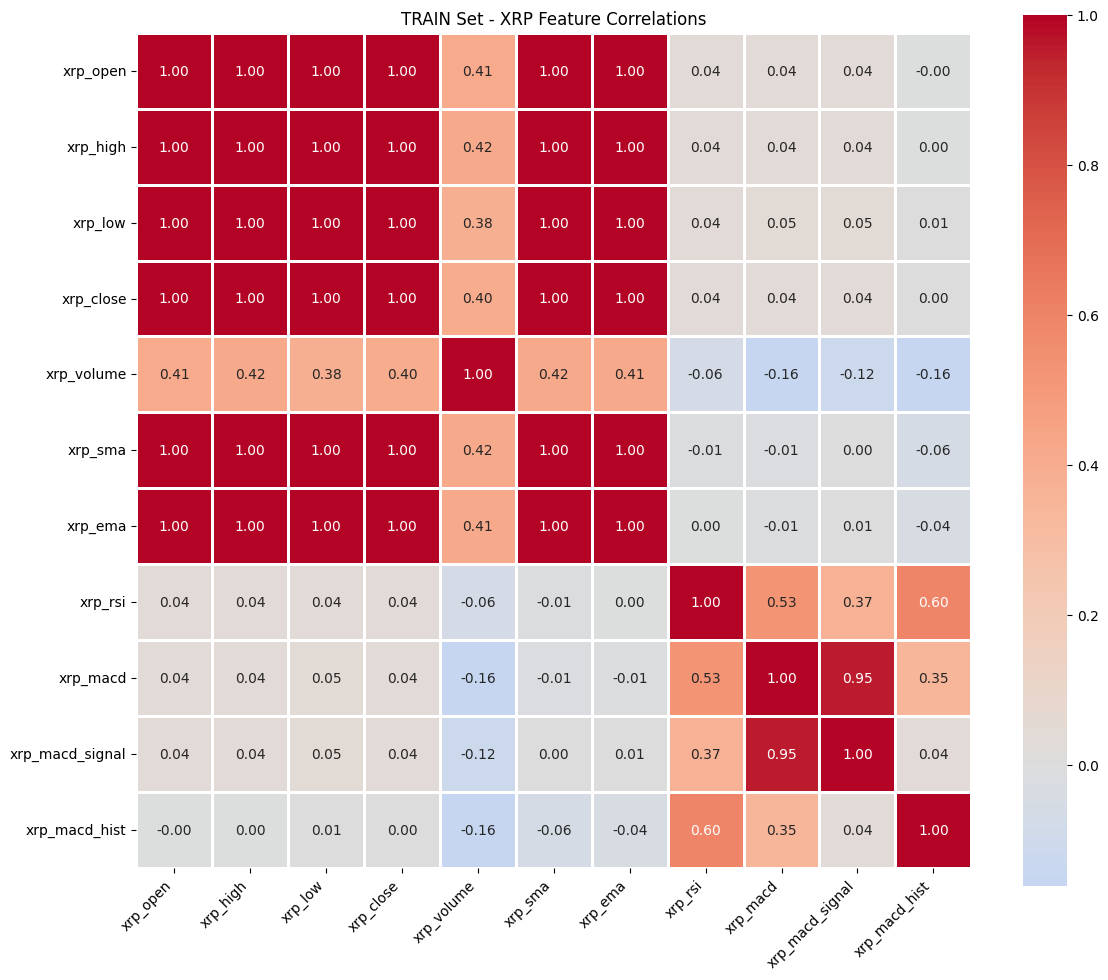

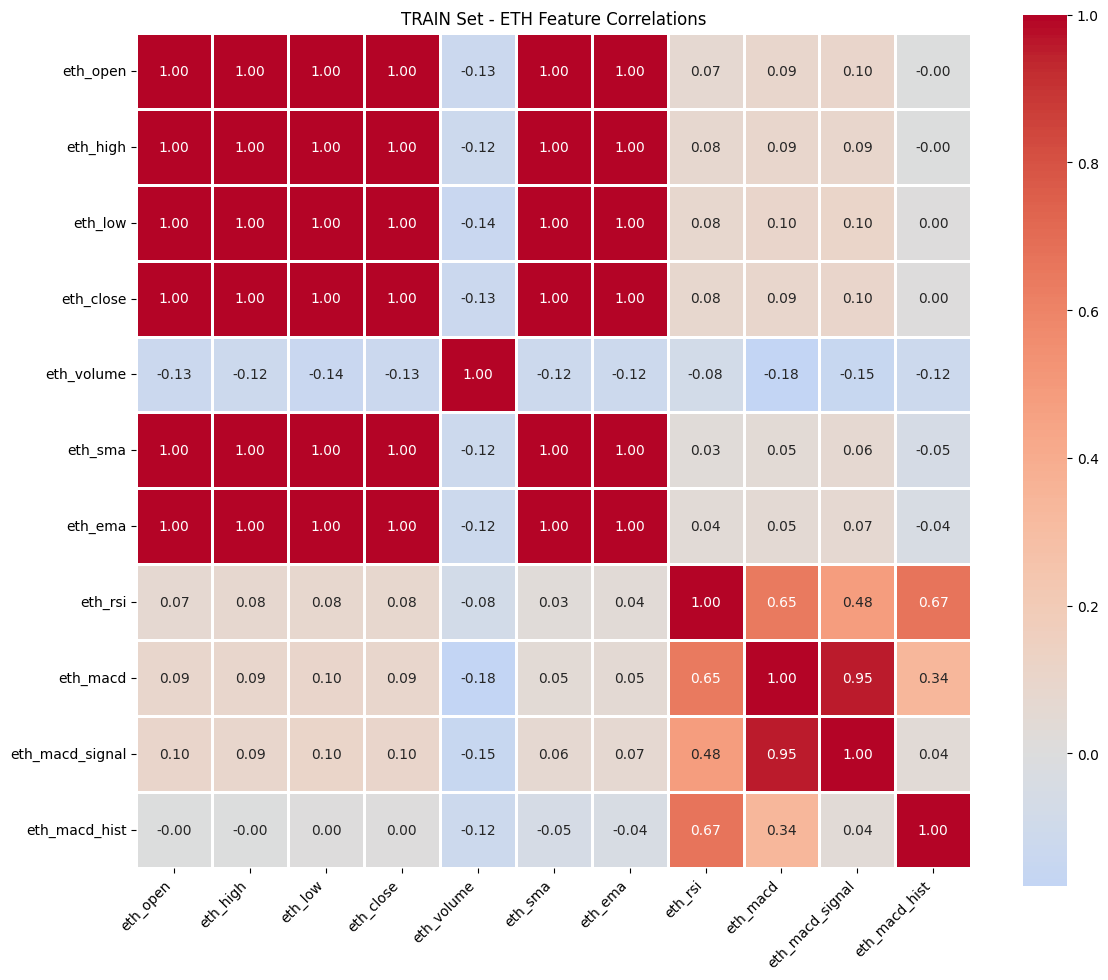

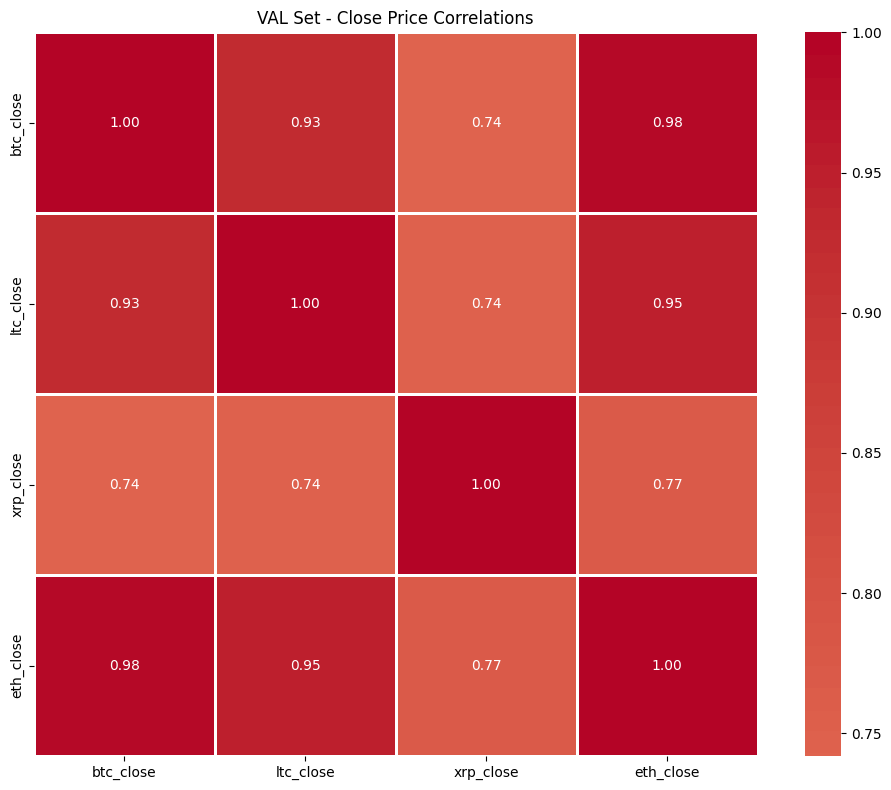

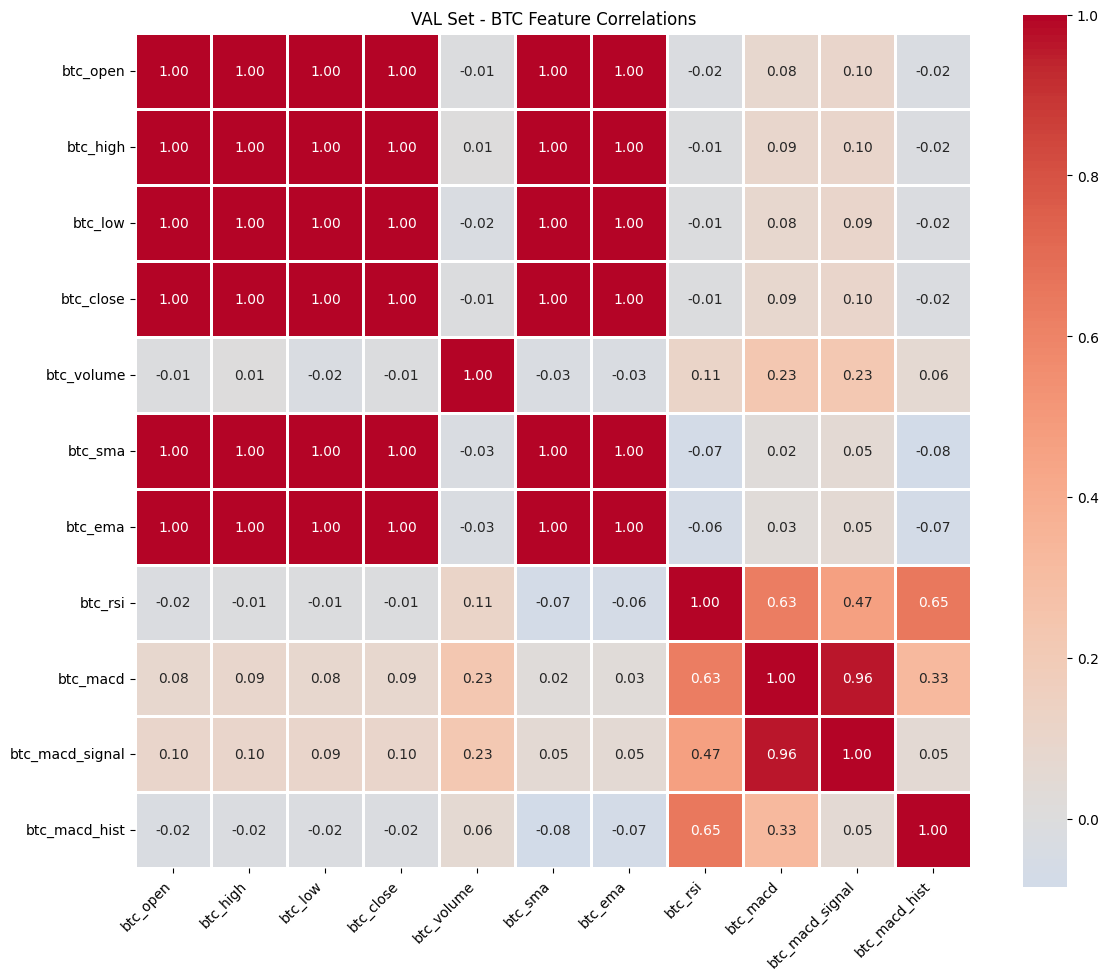

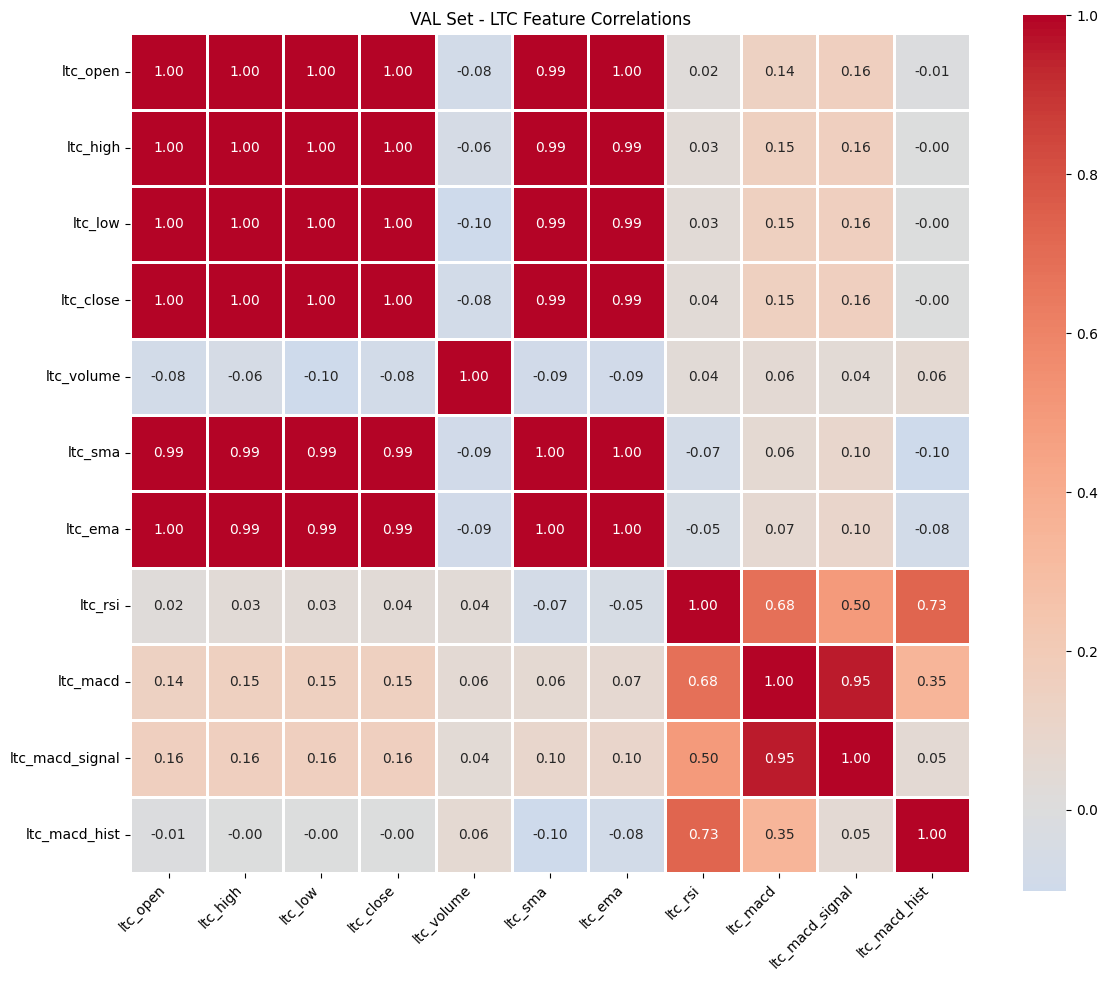

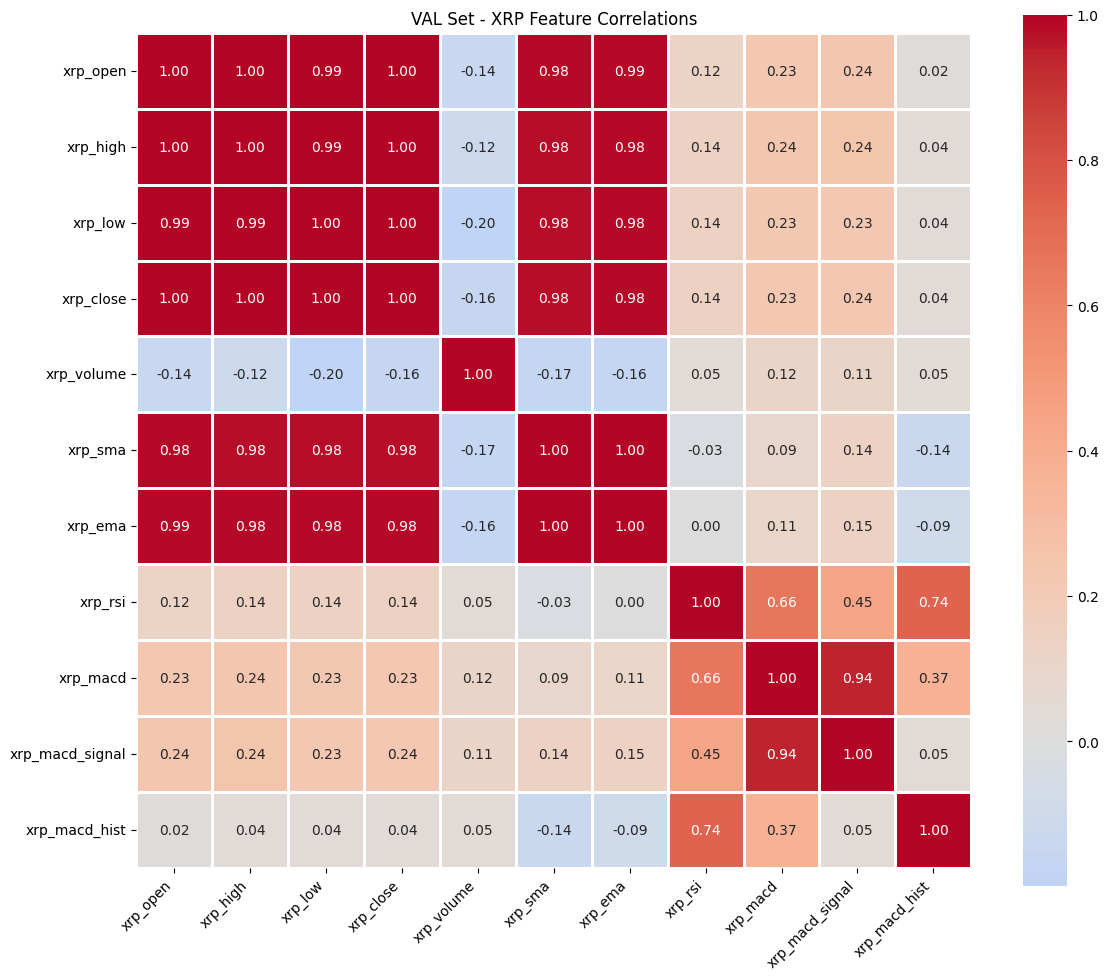

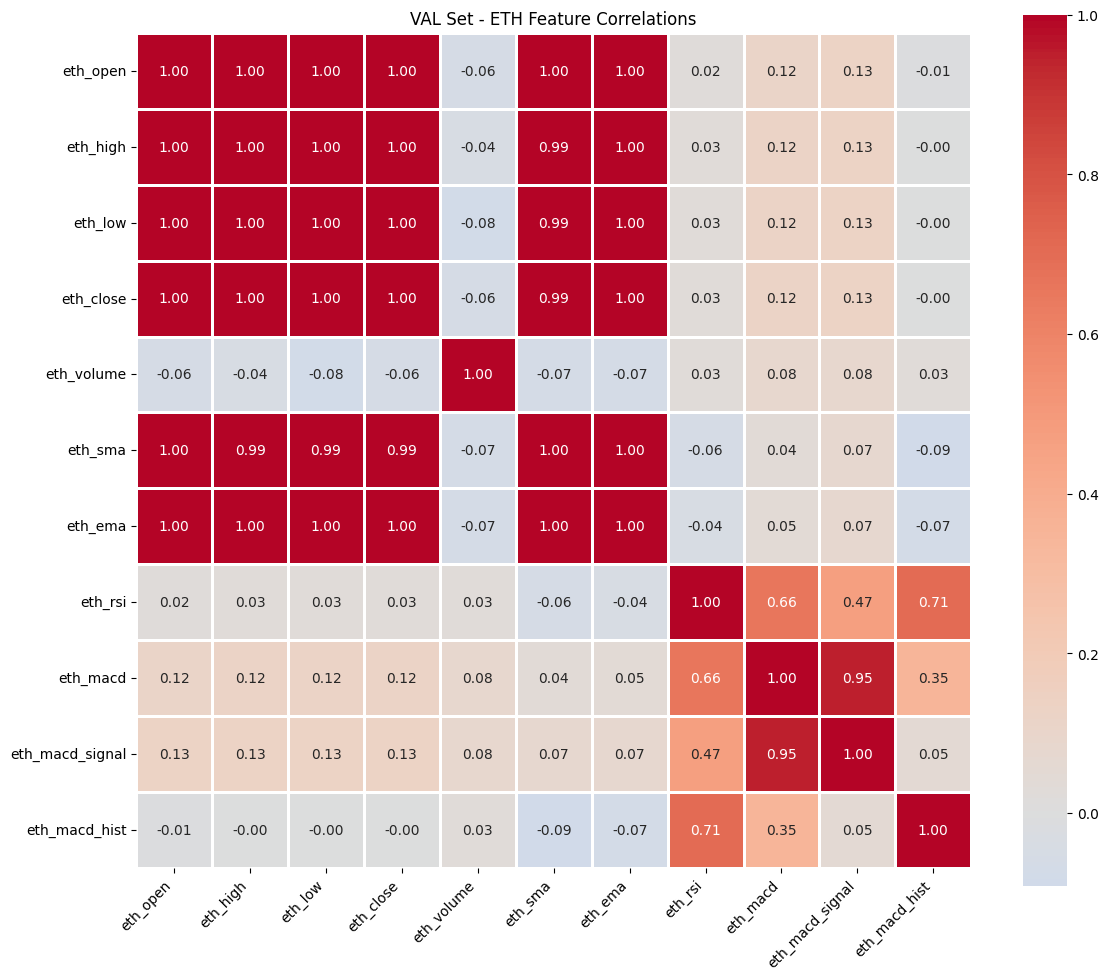

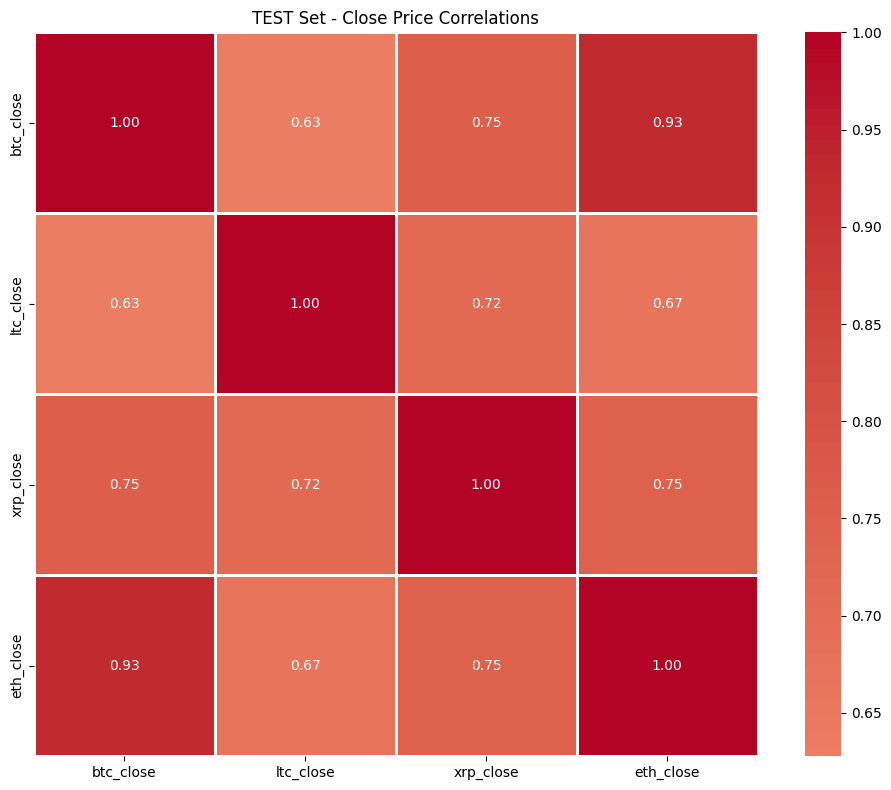

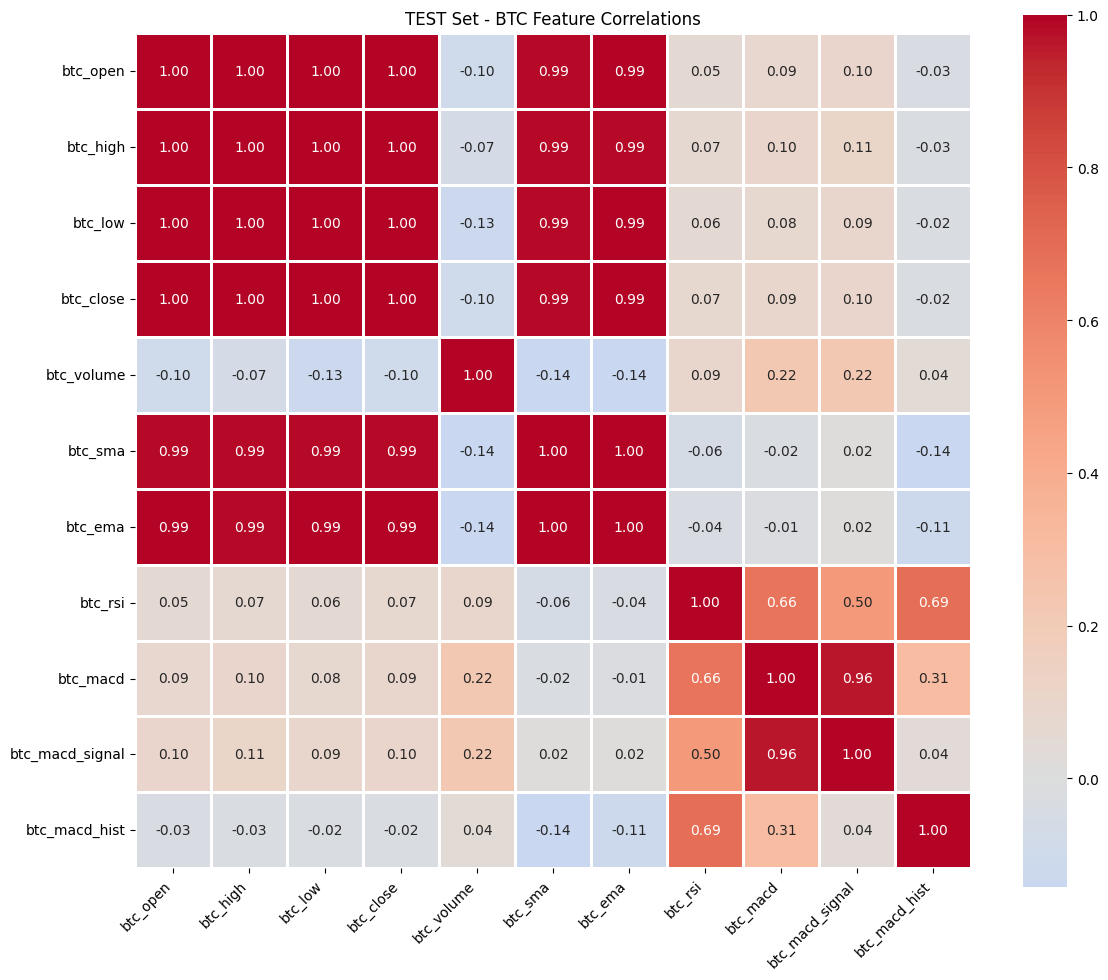

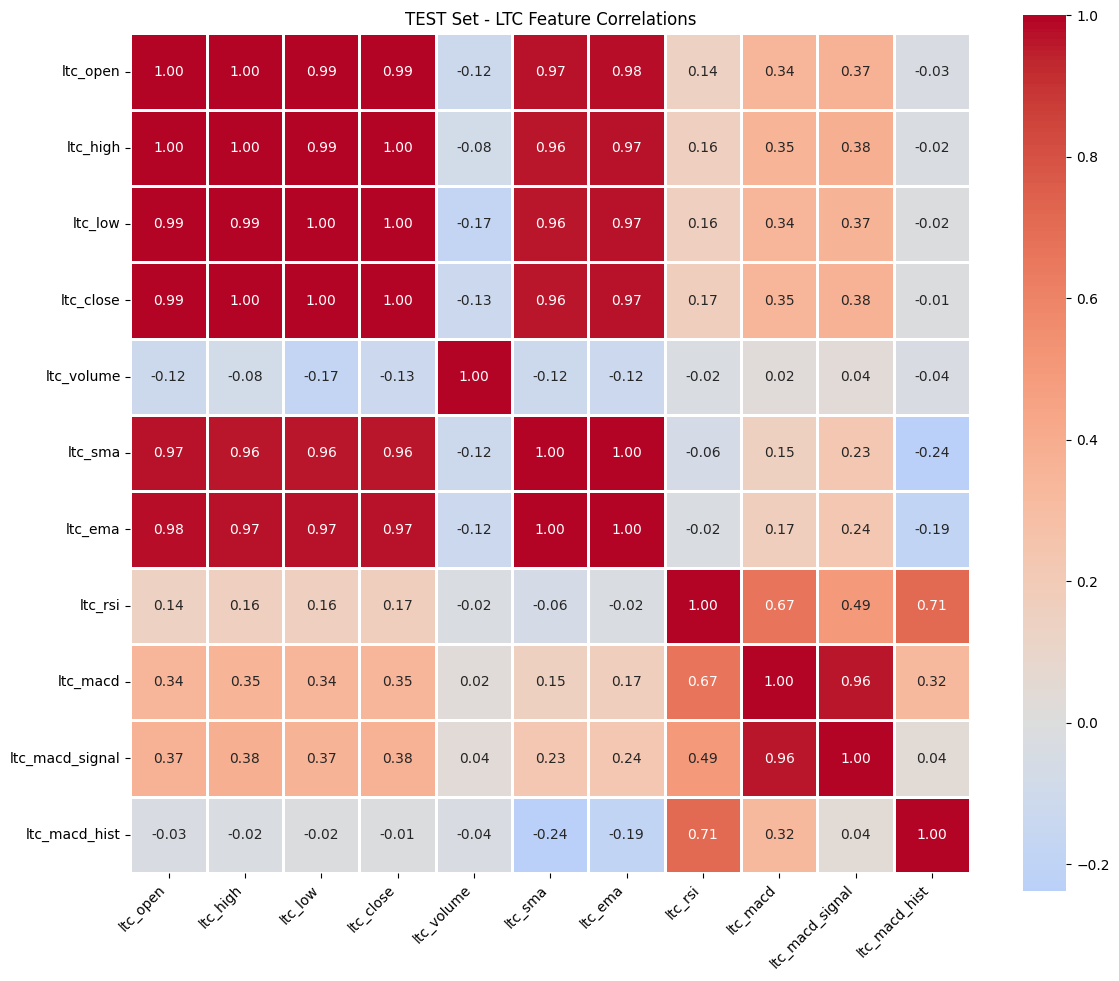

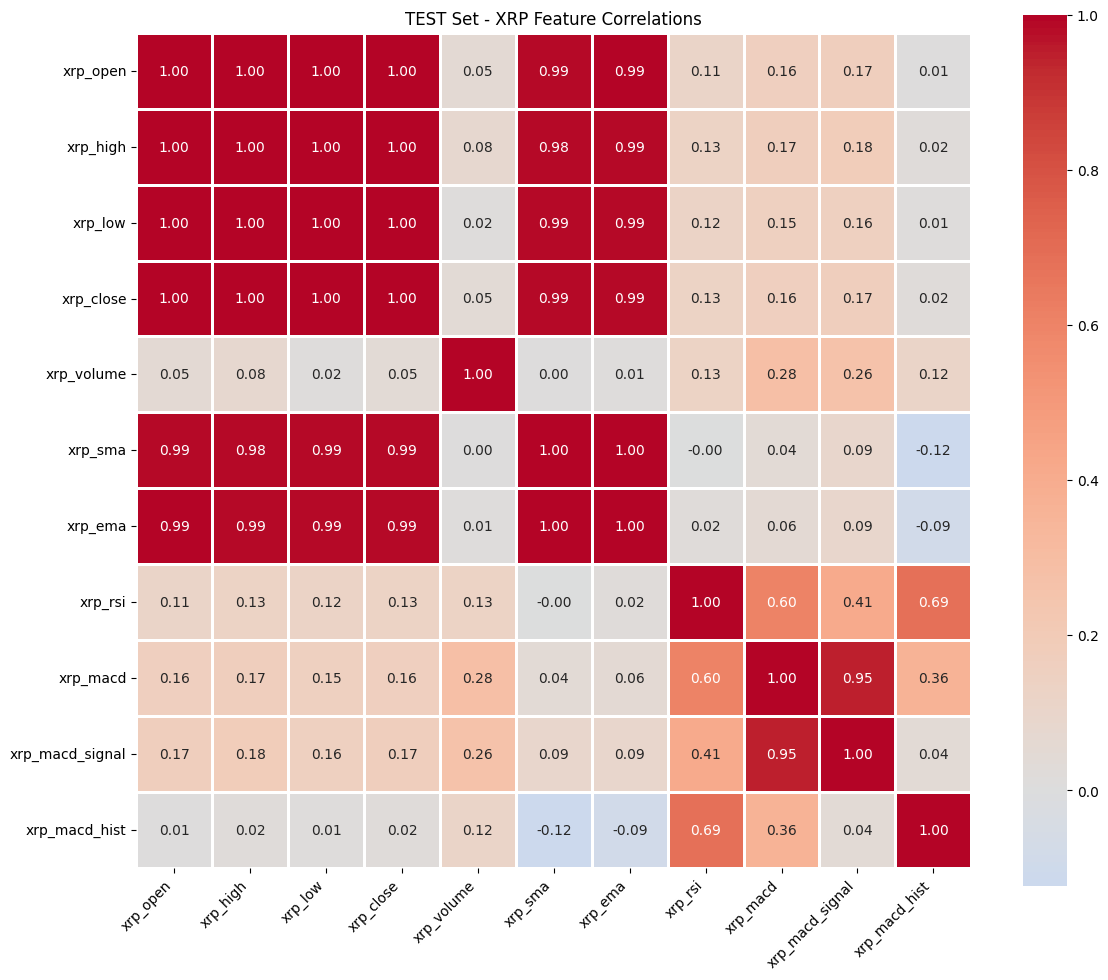

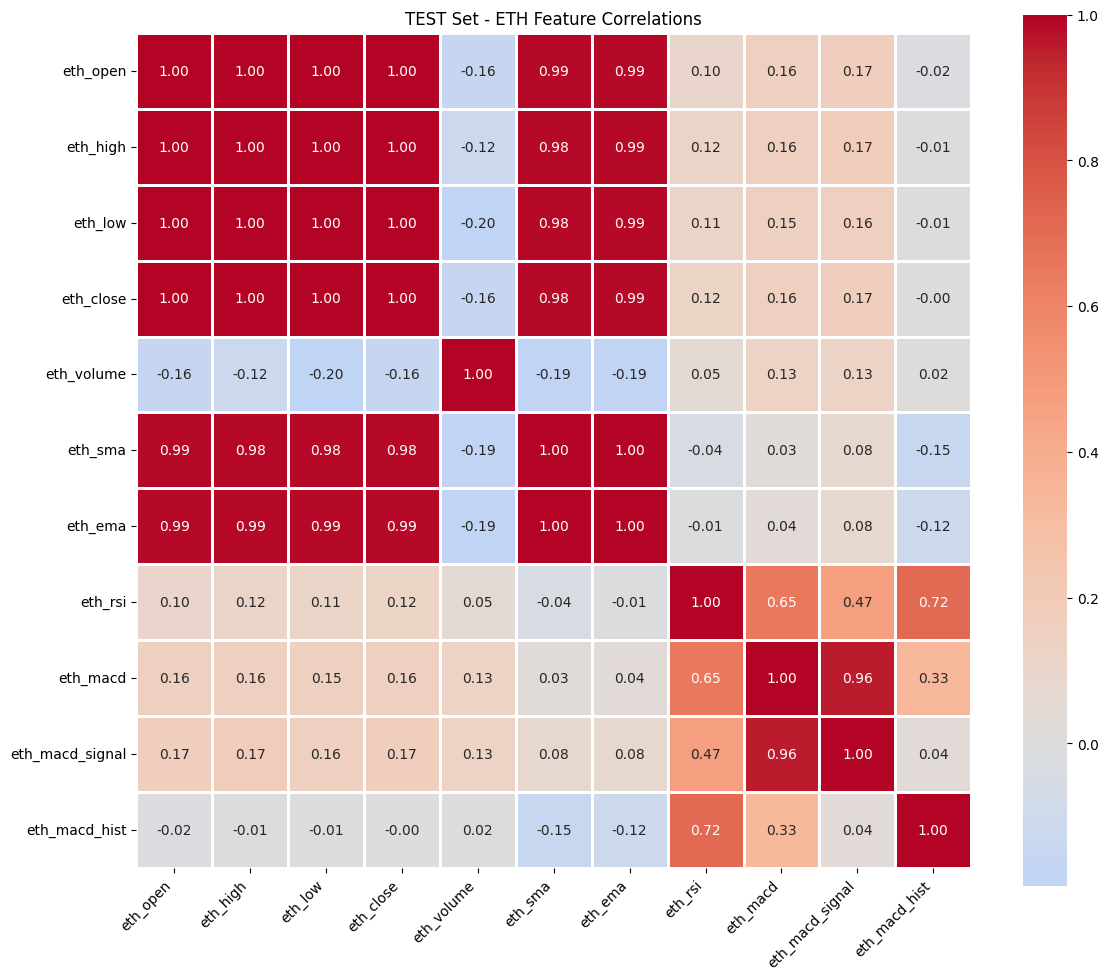

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmaps(processed_data, all_coins):
    """
    Her set için korelasyon heatmap'lerini oluşturur
    """
    for data_type in ['train', 'val', 'test']:
        # 1. Tüm coinlerin kapanış fiyatları arasındaki korelasyon
        plt.figure(figsize=(10, 8))
        close_cols = [f'{coin}_close' for coin in all_coins]
        close_corr = processed_data[data_type][close_cols].corr()

        sns.heatmap(close_corr, annot=True, cmap='coolwarm', center=0,
                   fmt='.2f', square=True, linewidths=1)
        plt.title(f'{data_type.upper()} Set - Close Price Correlations')
        plt.tight_layout()
        plt.show()

        # 2. Her coin için özellikler arası korelasyon
        for coin in all_coins:
            coin_cols = [col for col in processed_data[data_type].columns if col.startswith(coin)]
            coin_df = processed_data[data_type][coin_cols]
            corr_matrix = coin_df.corr()

            plt.figure(figsize=(12, 10))
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                       fmt='.2f', square=True, linewidths=1)
            plt.title(f'{data_type.upper()} Set - {coin.upper()} Feature Correlations')
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()

# Korelasyon heatmap'lerini oluştur
plot_correlation_heatmaps(processed_data, all_coins)

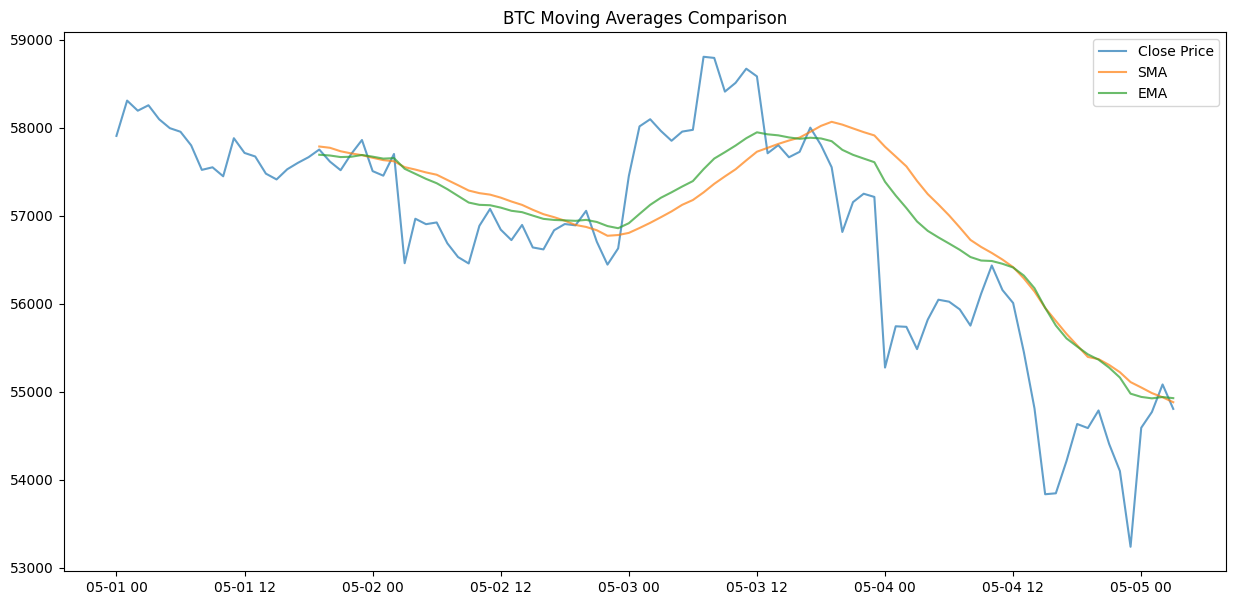

Max difference between SMA and EMA: 1128.31
Mean difference between SMA and EMA: 114.72


In [ ]:
## SMA ve EMA"nin korelasyonlari neredeyse 1'e esit olmasi garip. ayni trendi takip ediyorlar fakat bunlardan sadece feature selection icin birini secmemiz yeterli olacaktir.
def compare_ma_differences(df, coin):
    """
    SMA ve EMA arasındaki farkı görselleştir
    """
    plt.figure(figsize=(15, 7))
    plt.plot(df[f'{coin}_close'].iloc[:100], label='Close Price', alpha=0.7)
    plt.plot(df[f'{coin}_sma'].iloc[:100], label='SMA', alpha=0.7)
    plt.plot(df[f'{coin}_ema'].iloc[:100], label='EMA', alpha=0.7)
    plt.title(f'{coin.upper()} Moving Averages Comparison')
    plt.legend()
    plt.show()

    # Farkı yazdır
    diff = df[f'{coin}_sma'] - df[f'{coin}_ema']
    print(f"Max difference between SMA and EMA: {diff.abs().max():.2f}")
    print(f"Mean difference between SMA and EMA: {diff.abs().mean():.2f}")

# Test için
compare_ma_differences(processed_data['train'], 'btc')

<ipython-input-17-46570a873132>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


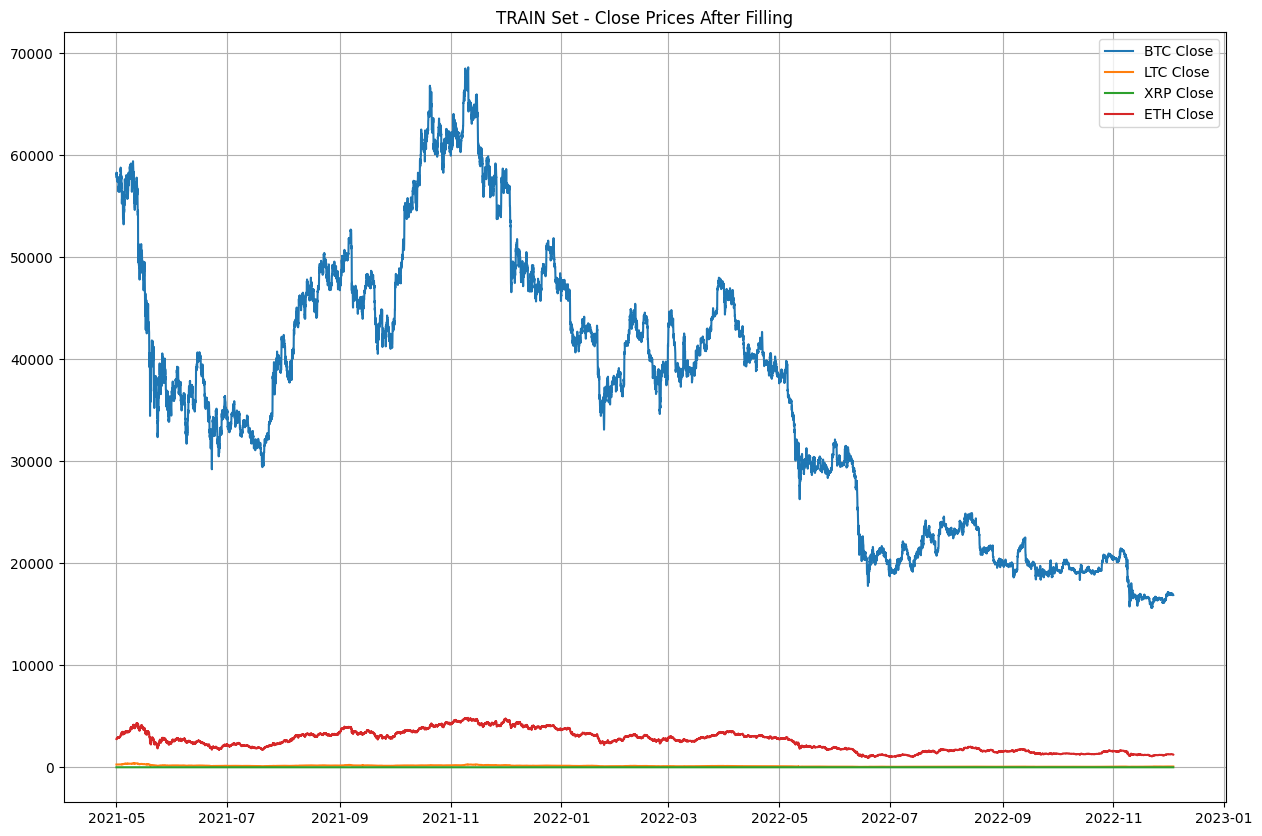

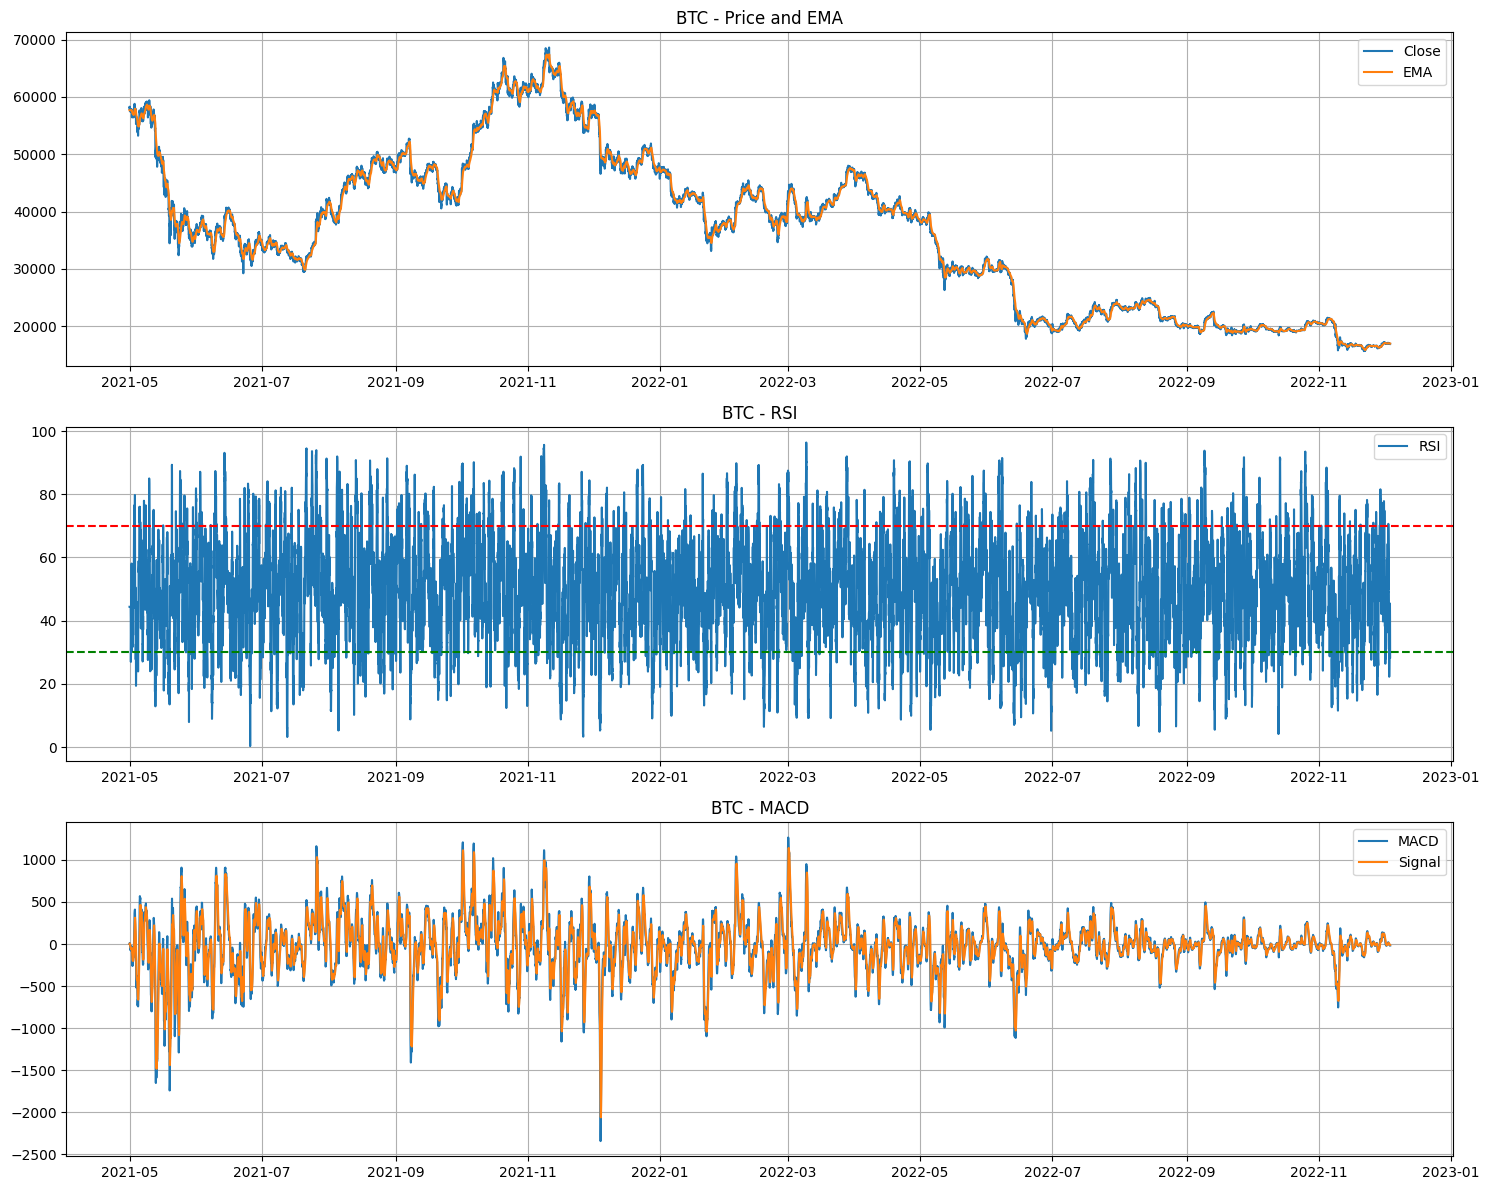

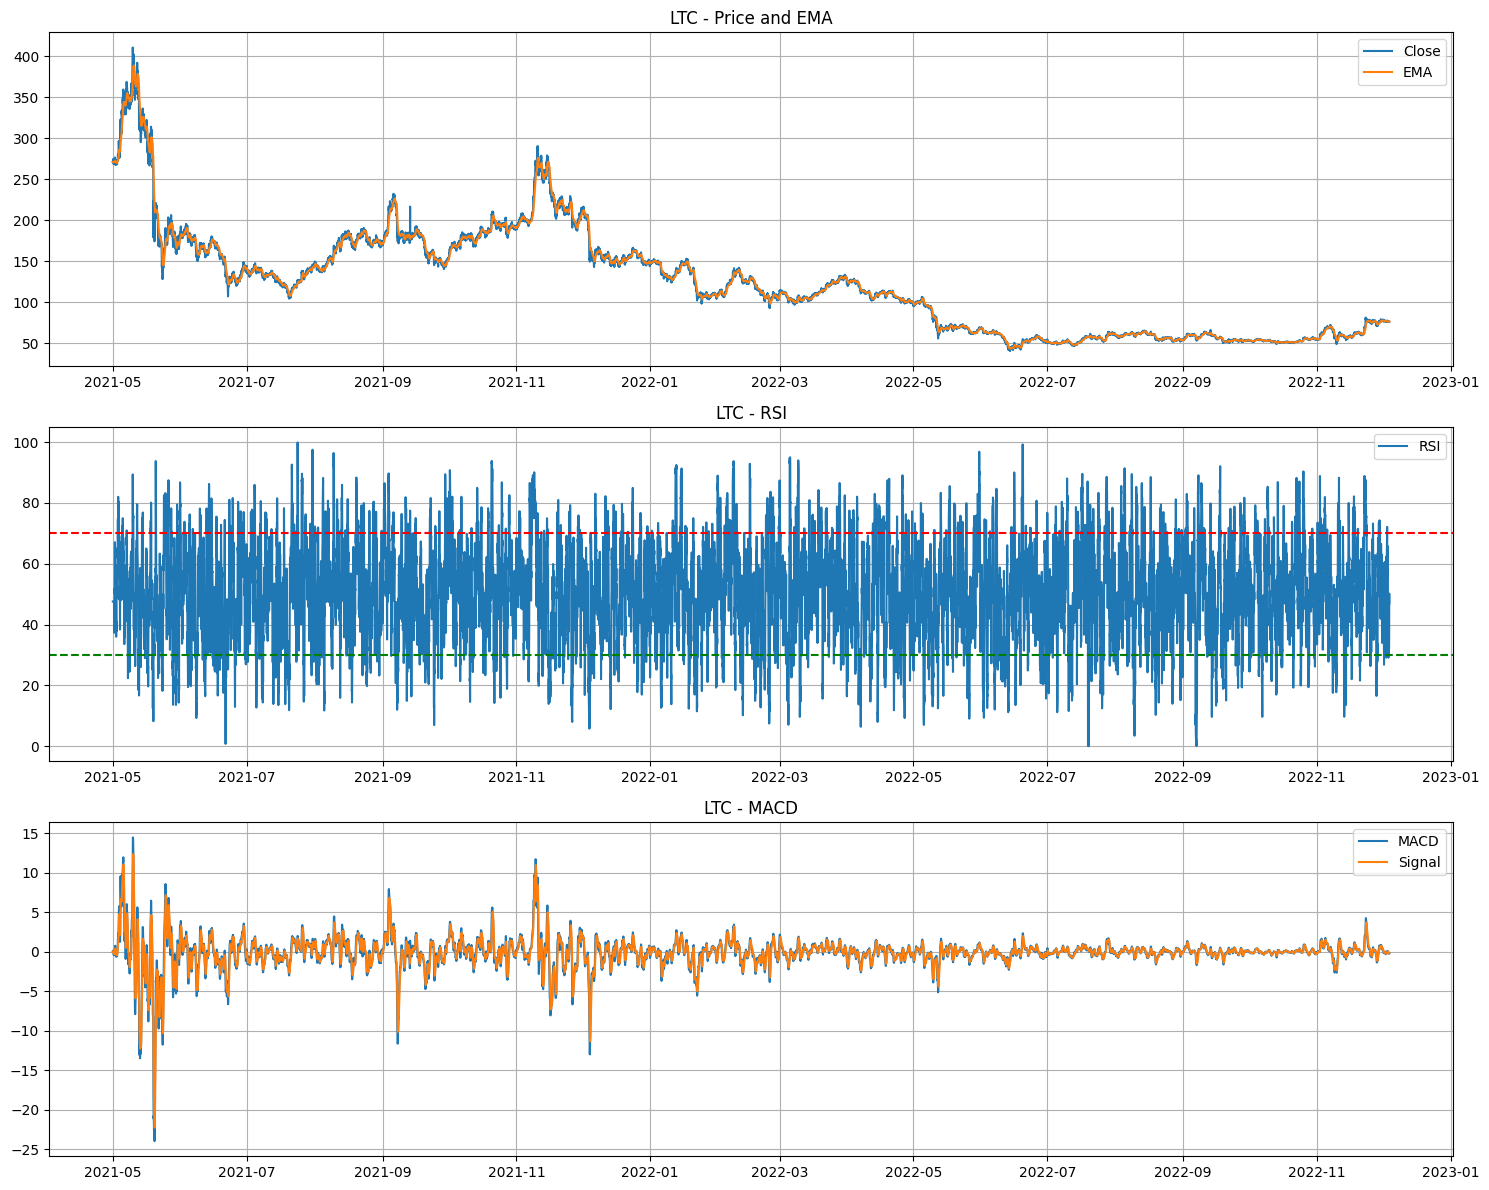

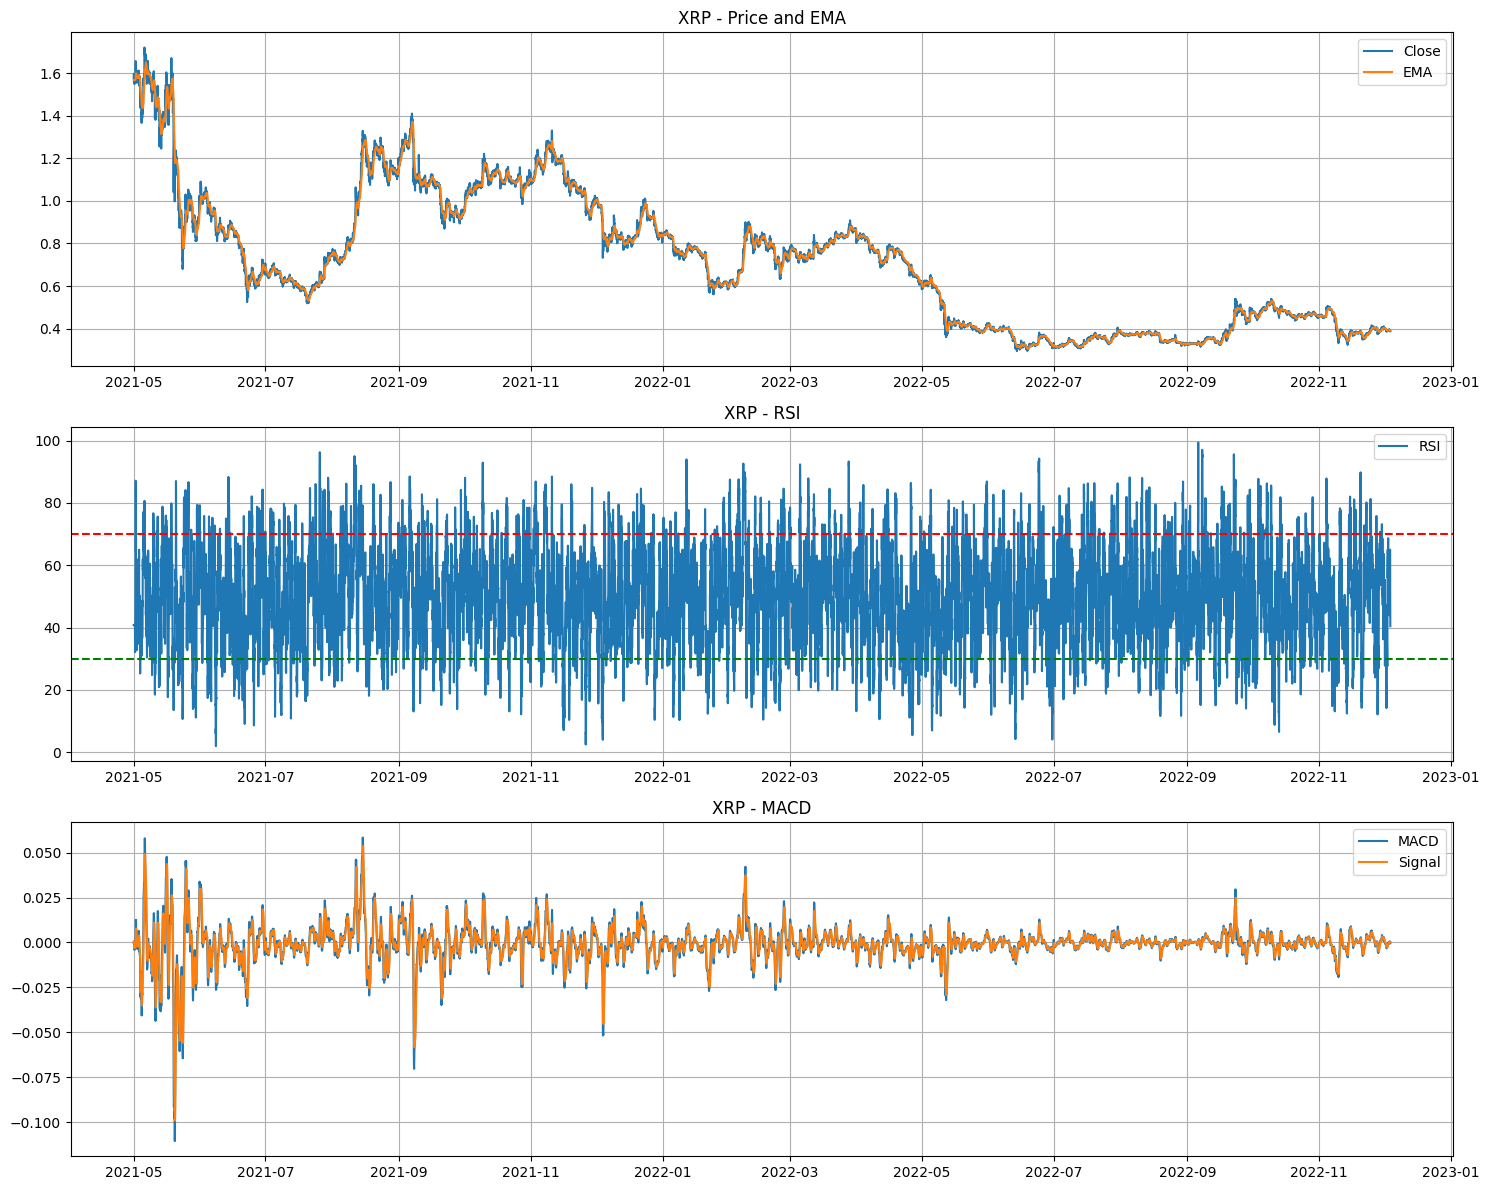

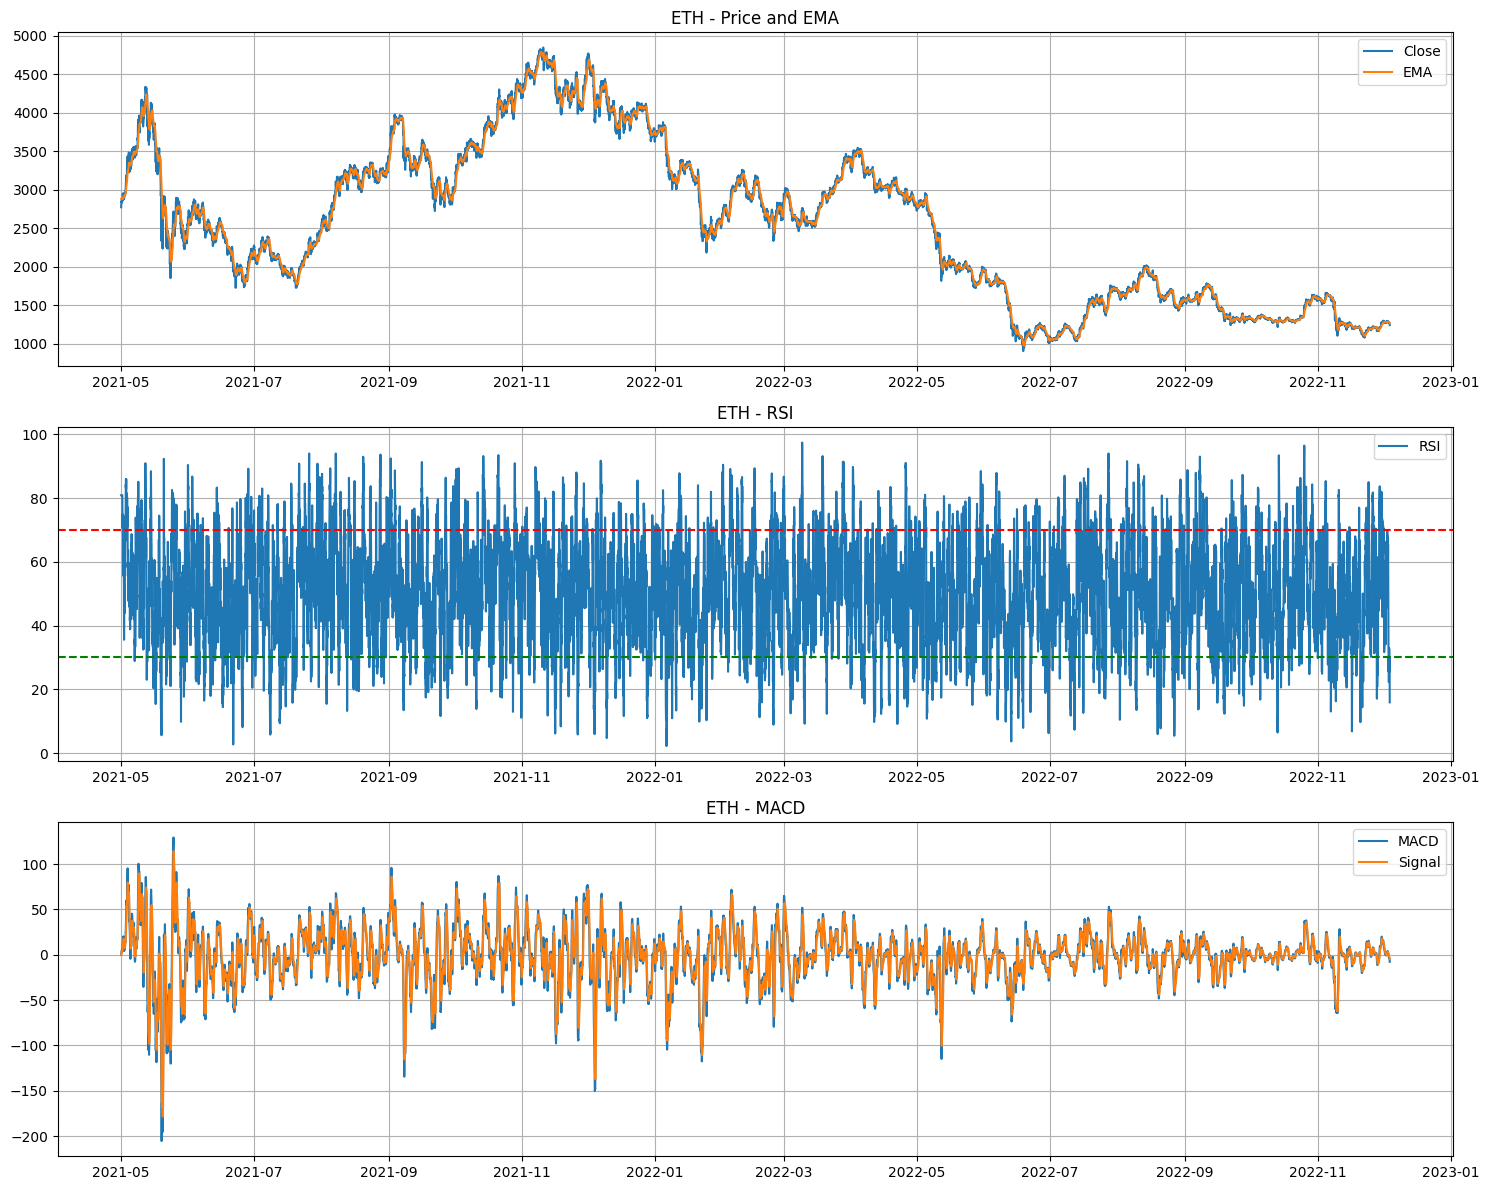

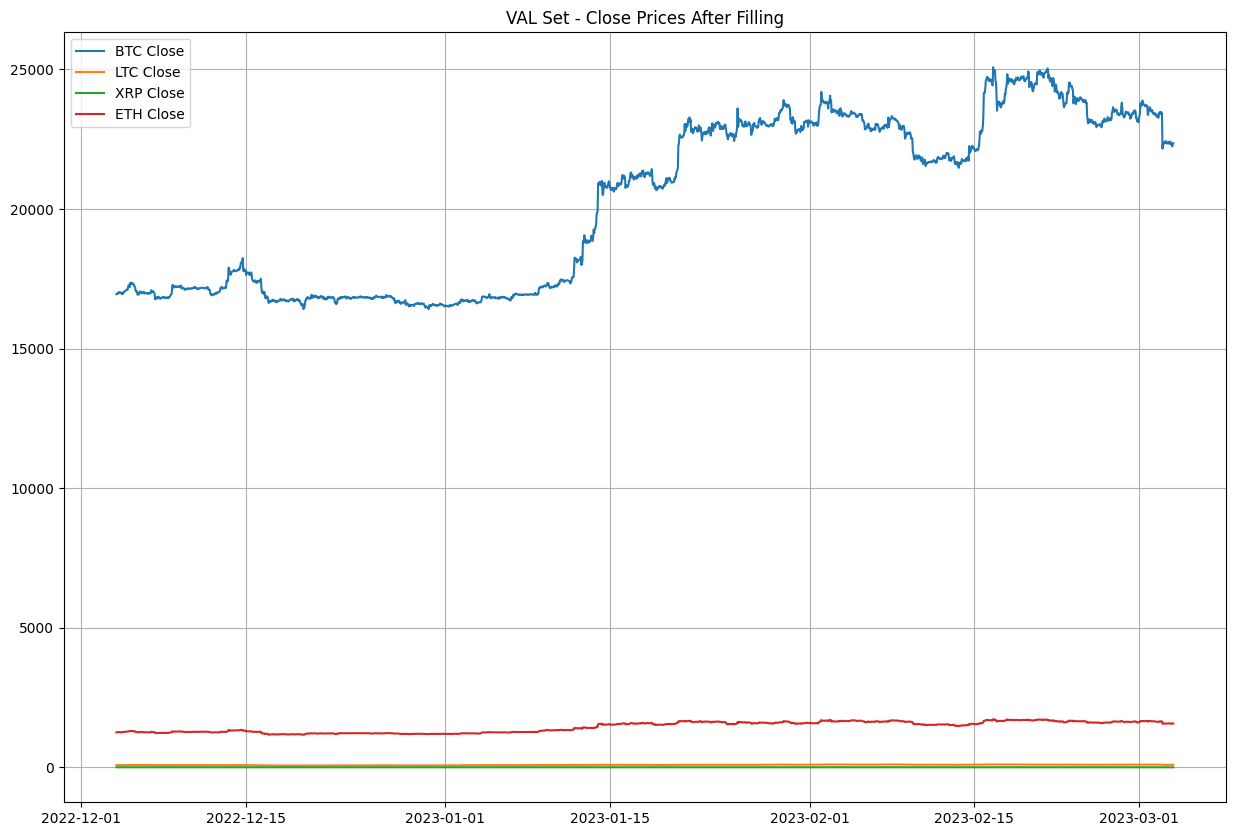

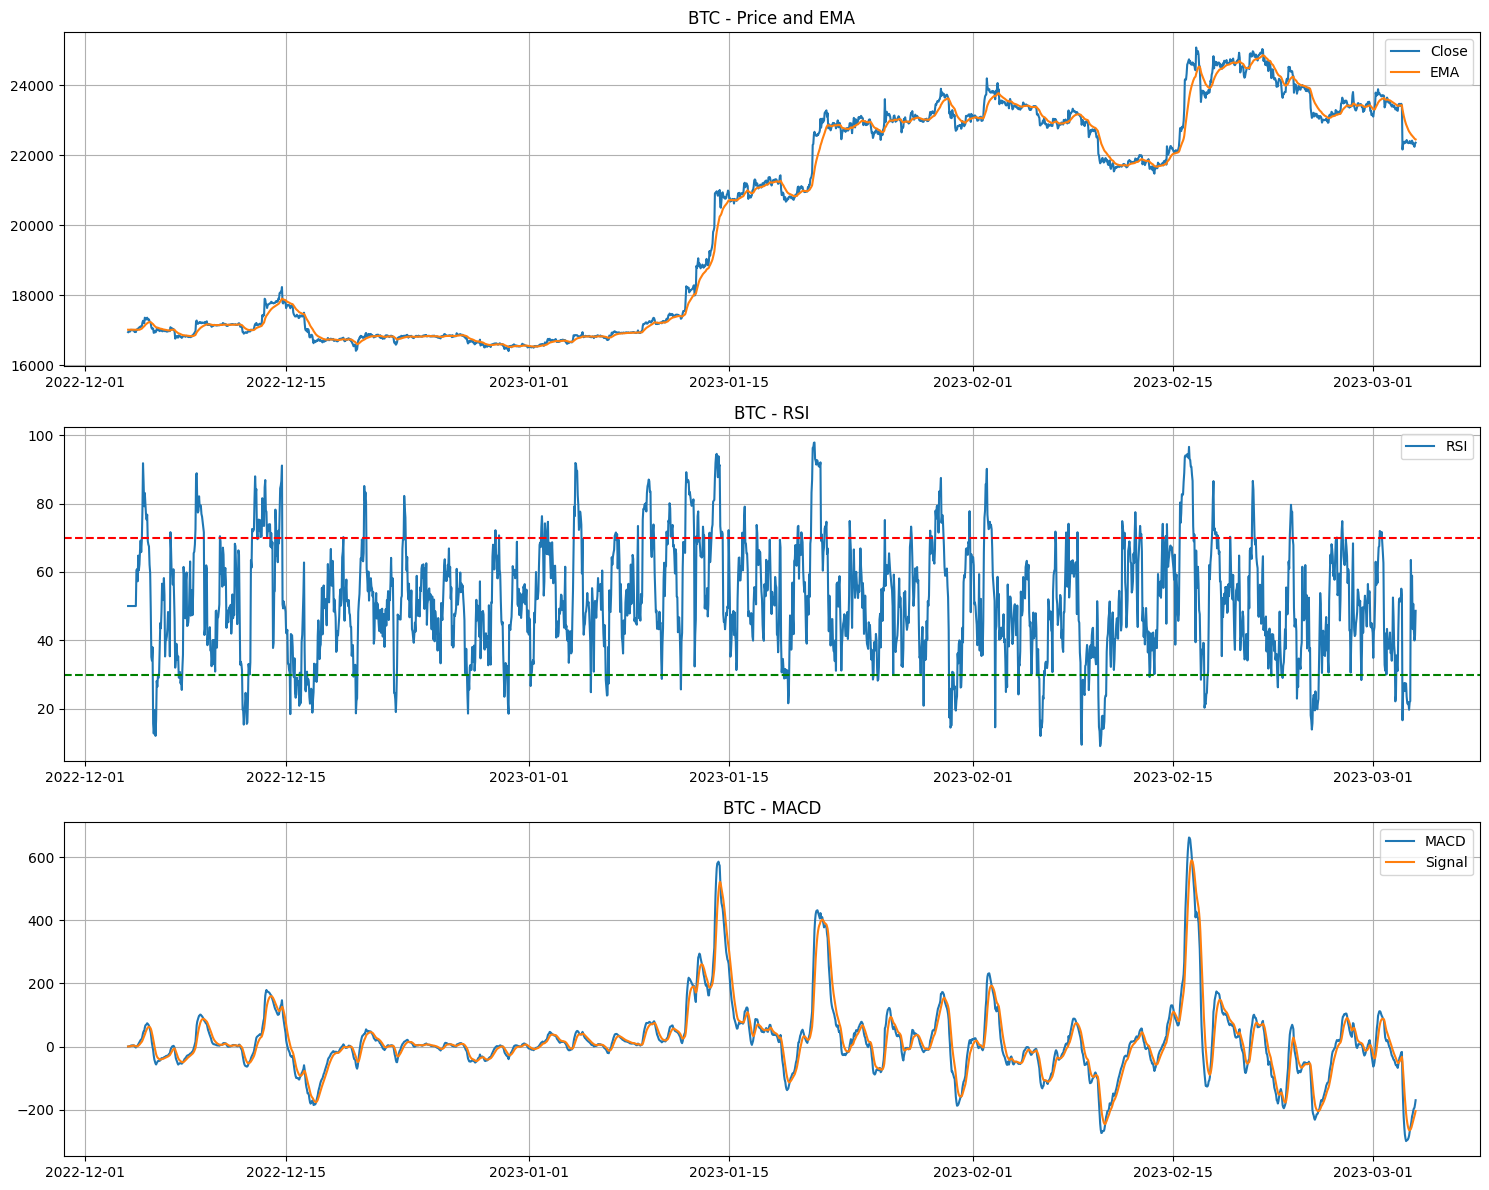

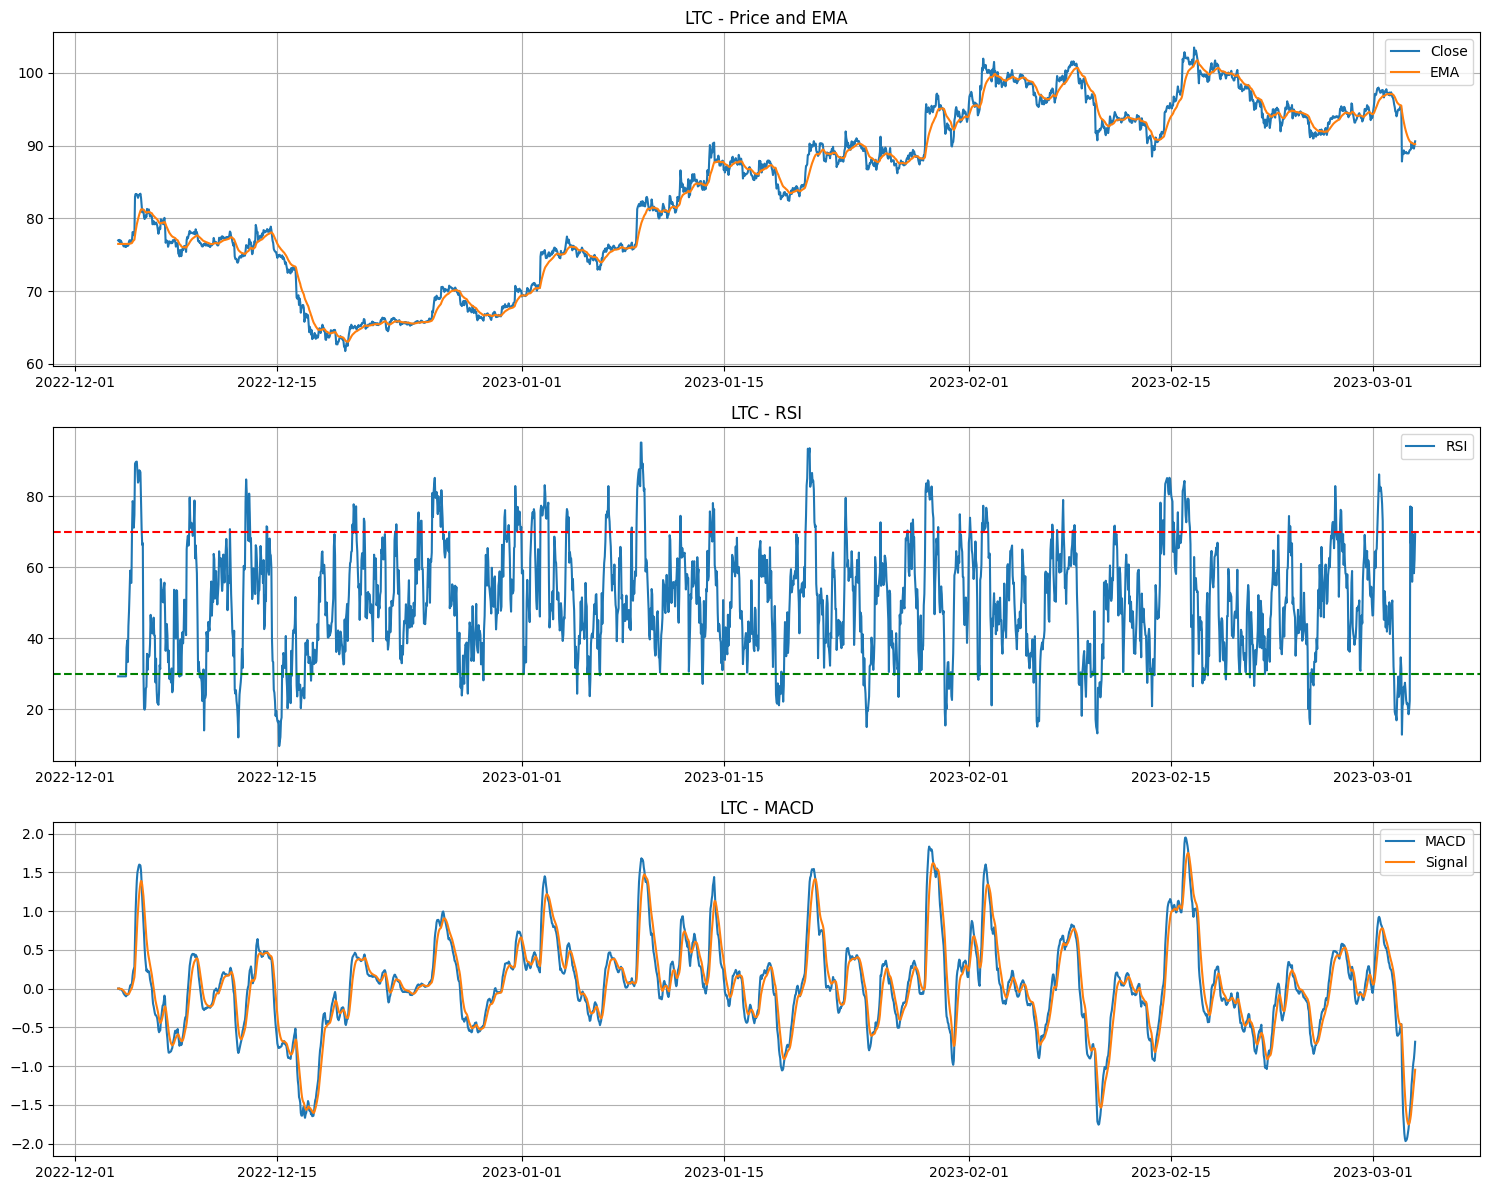

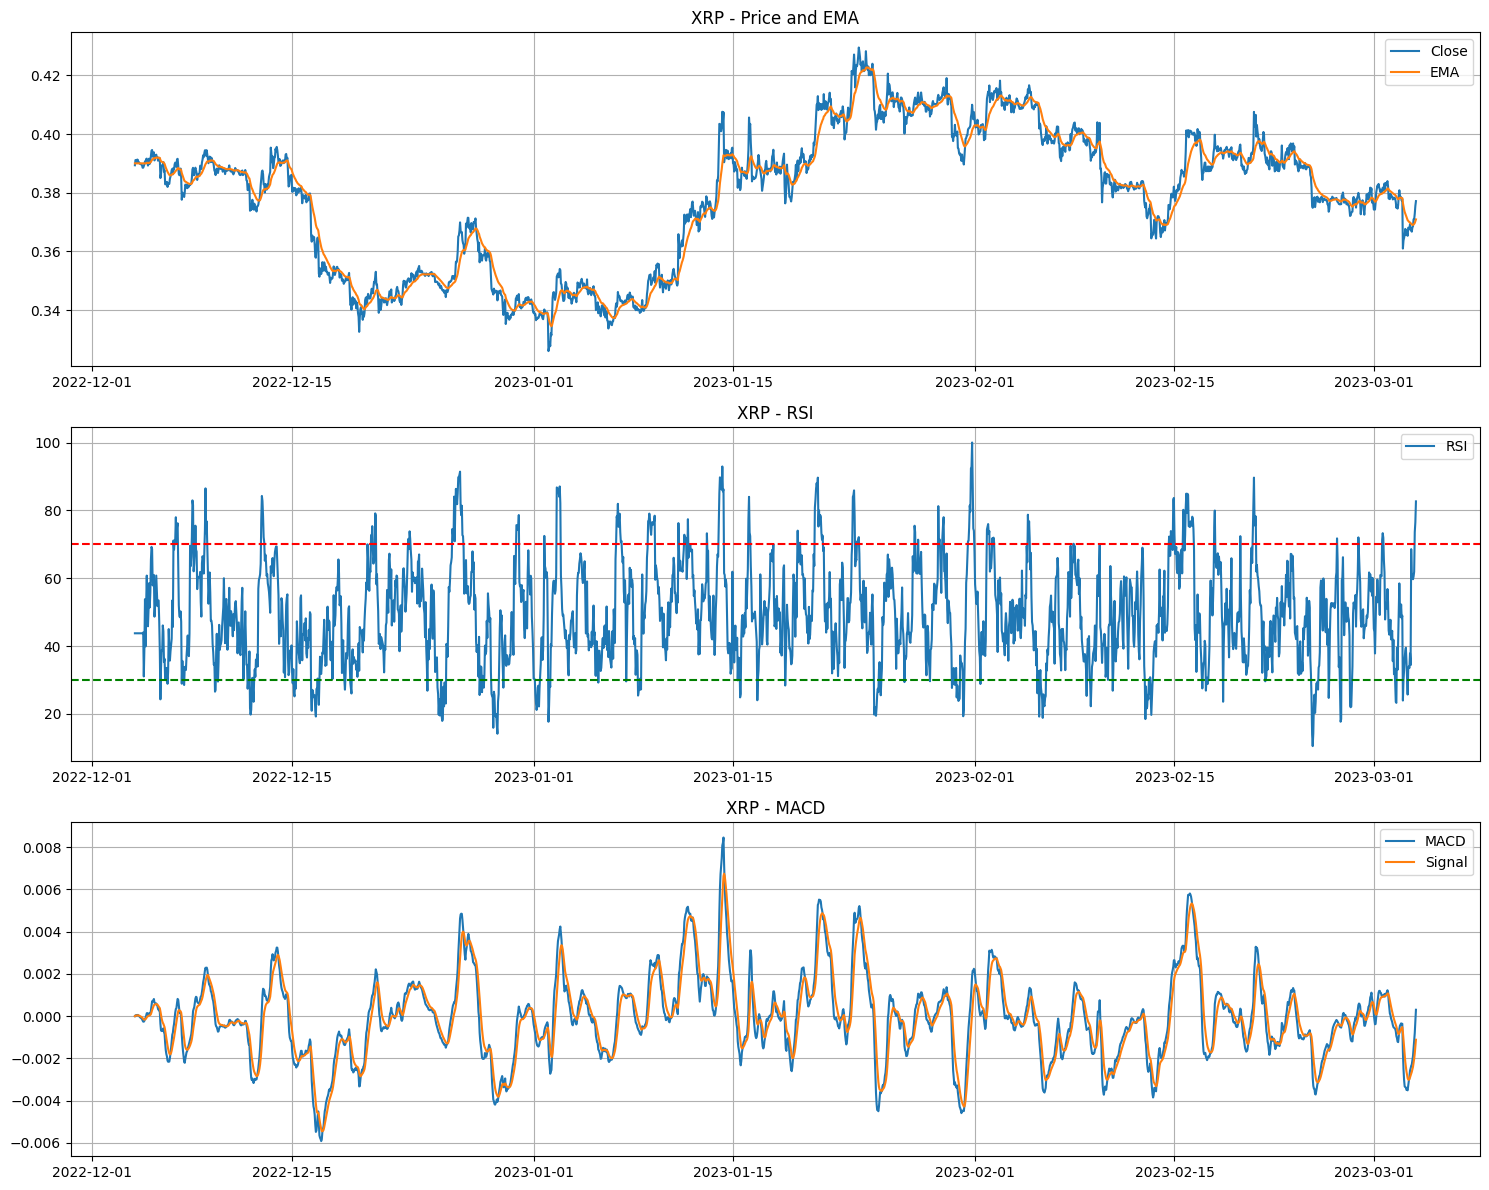

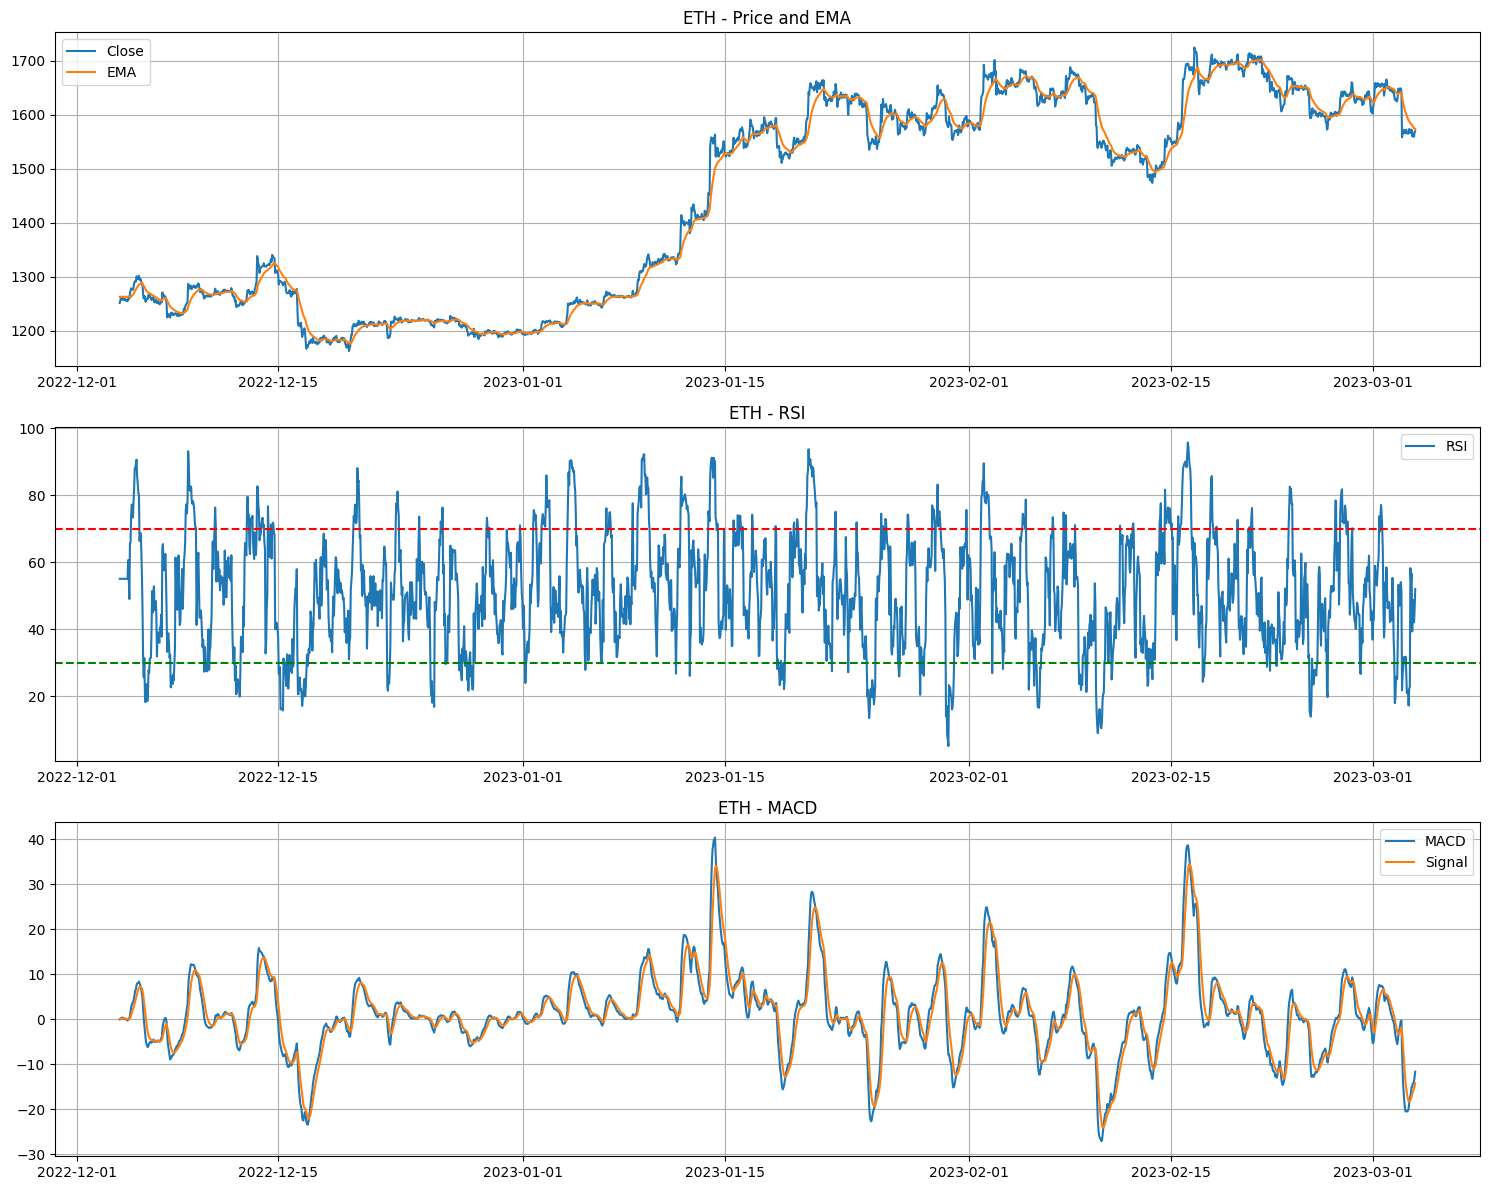

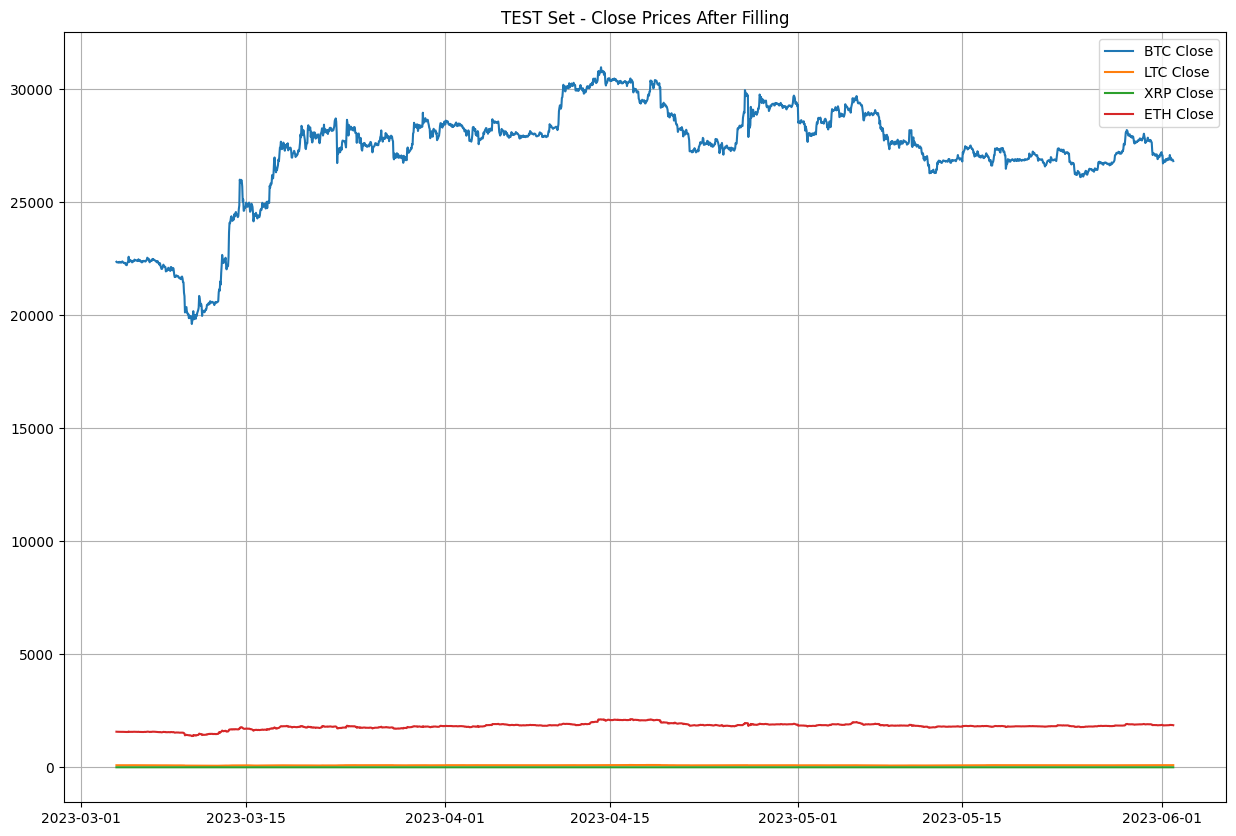

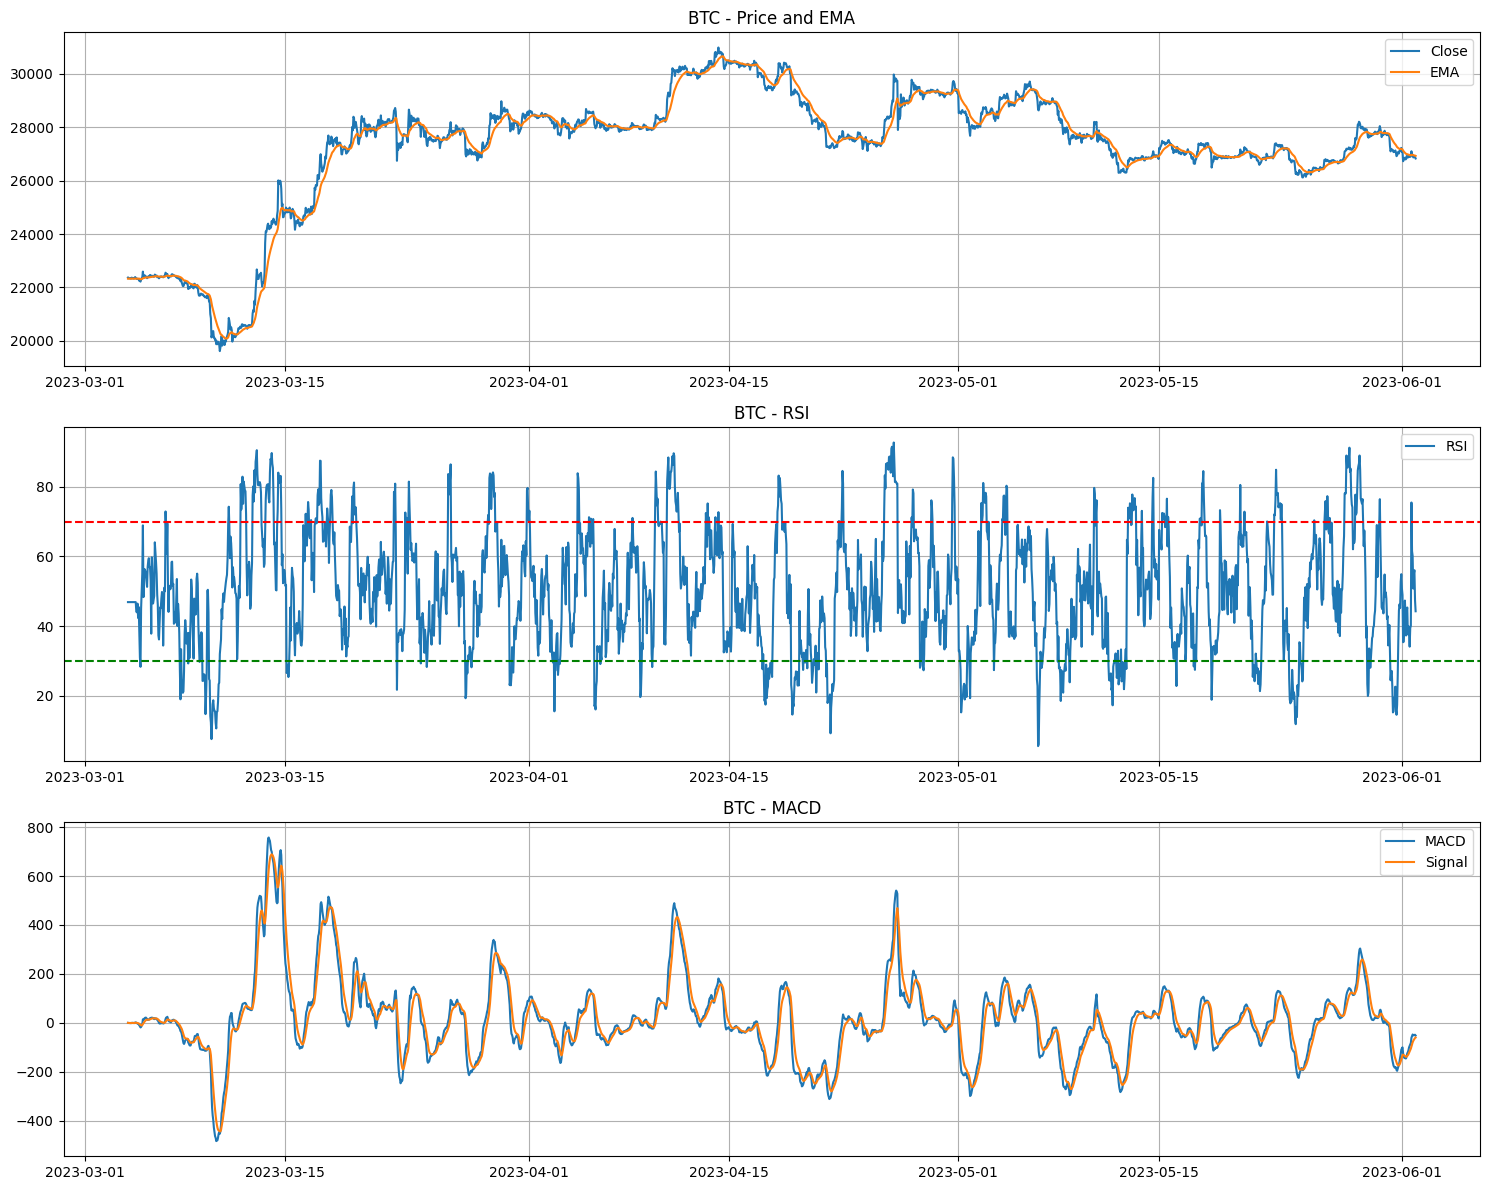

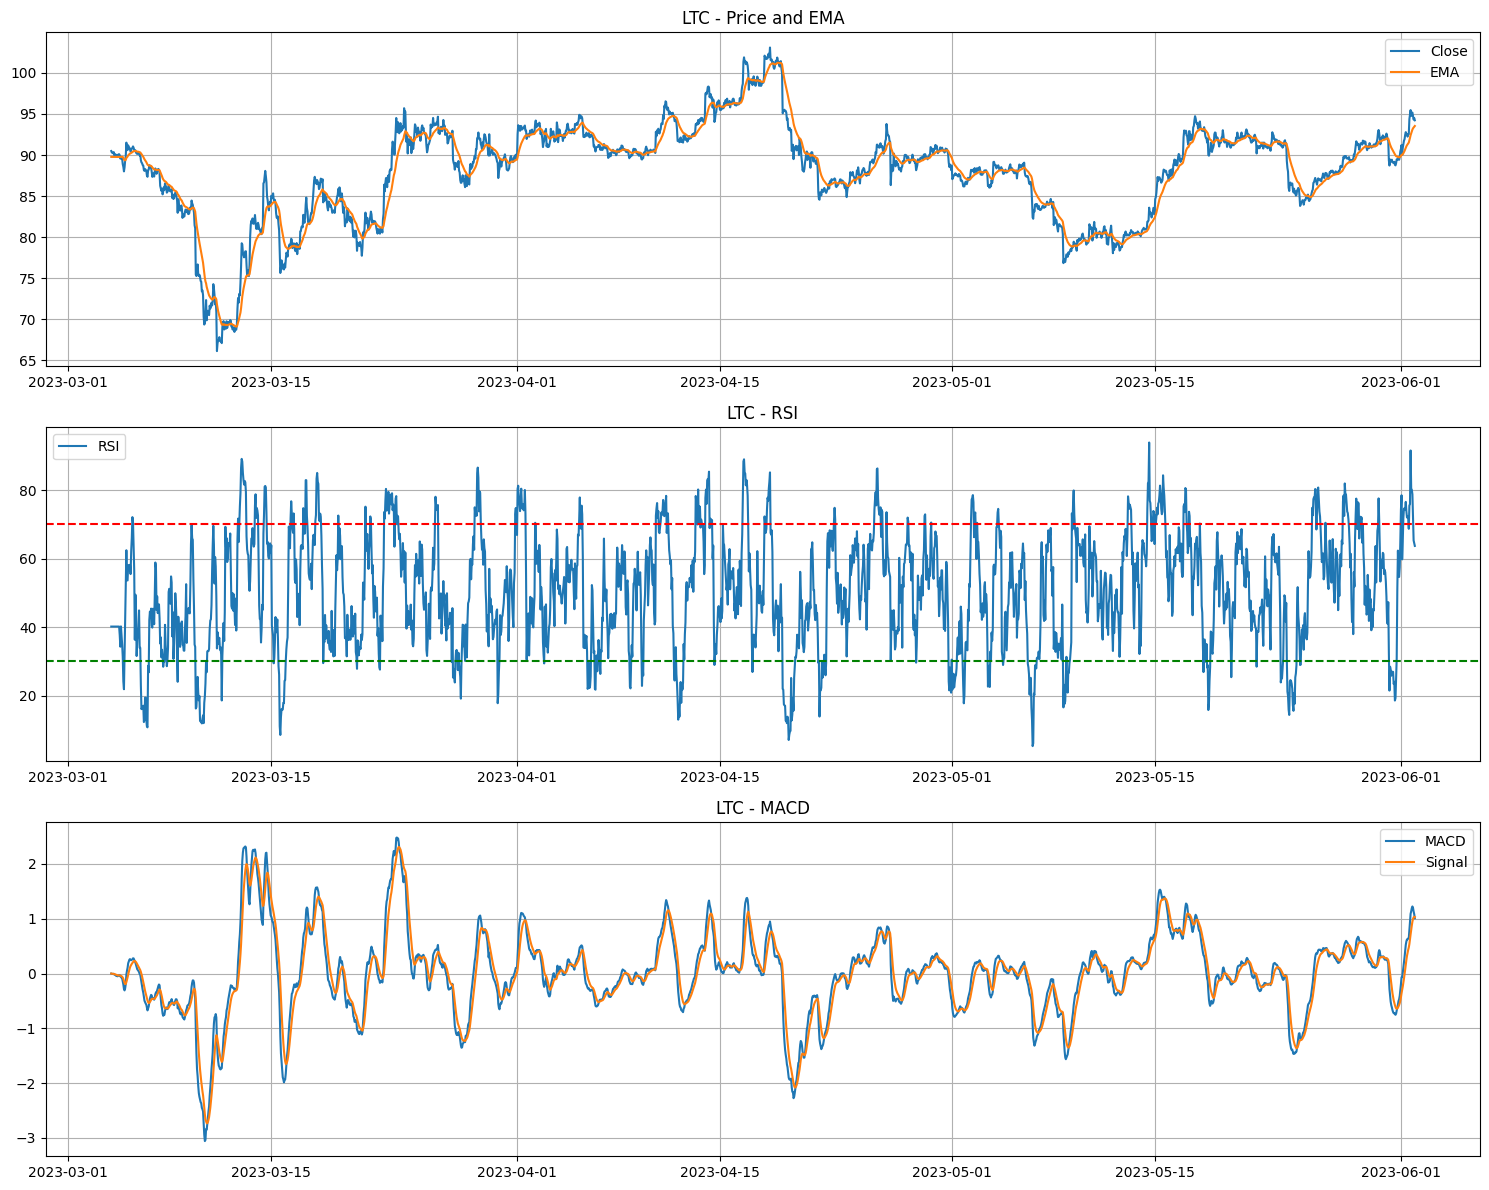

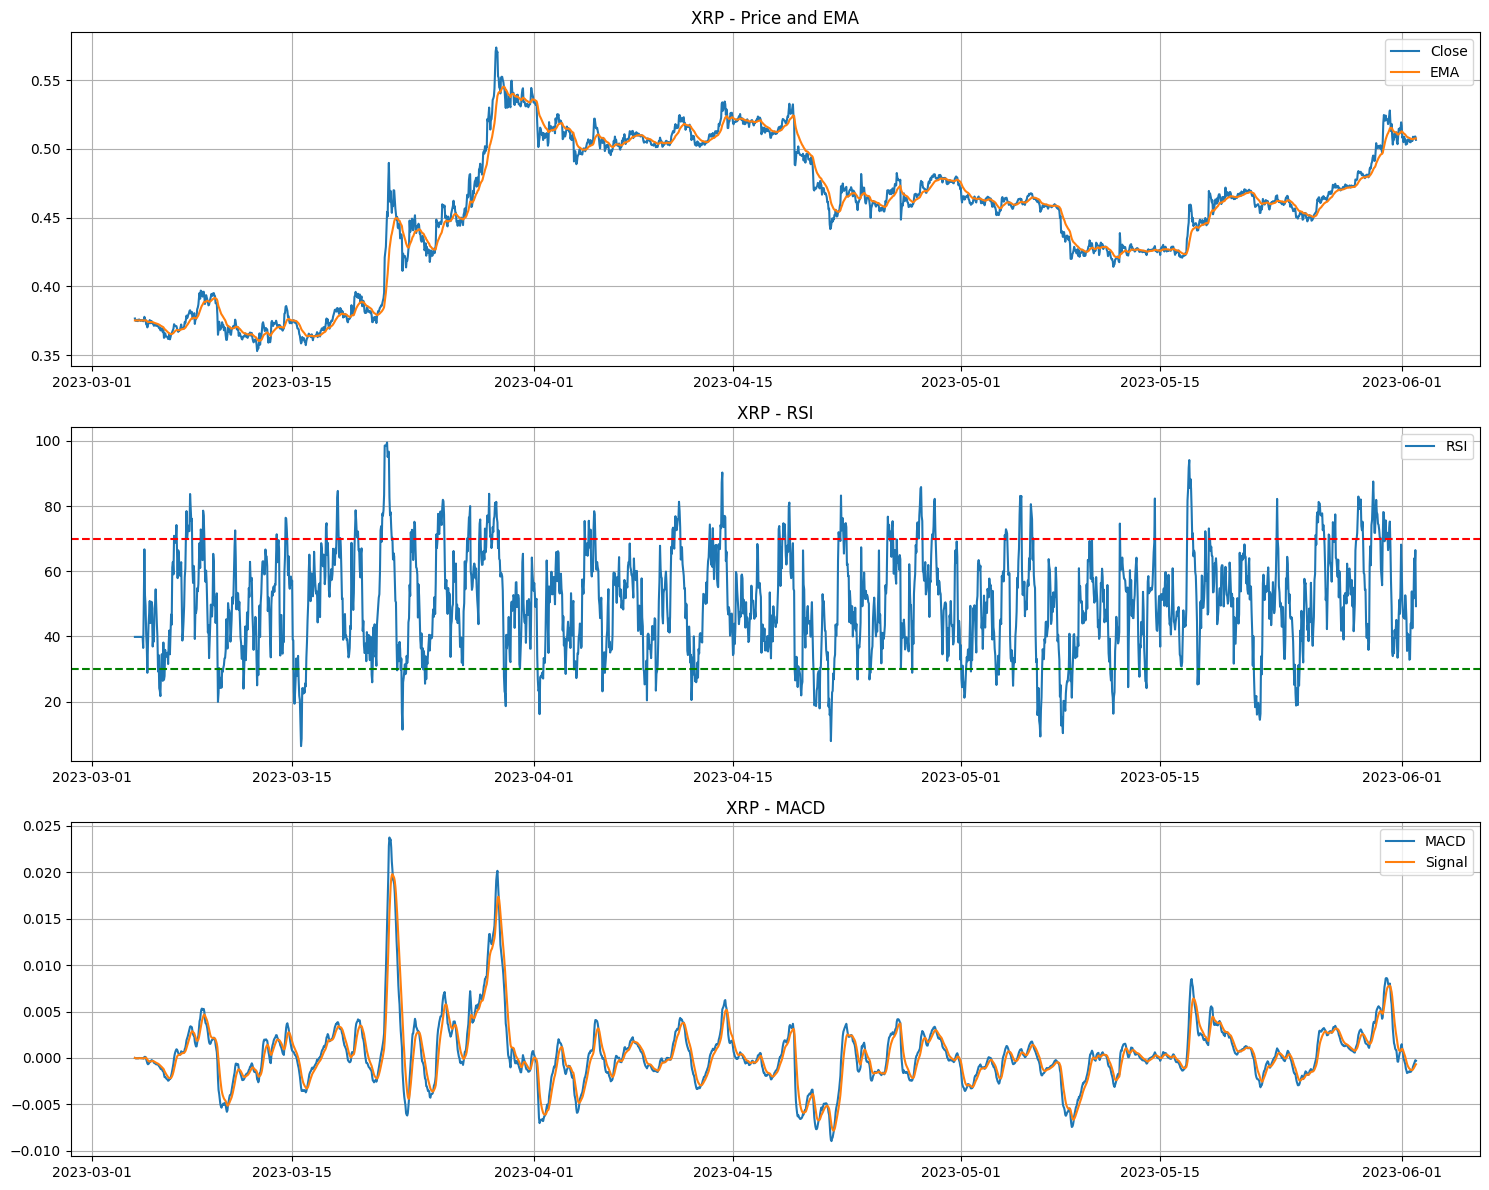

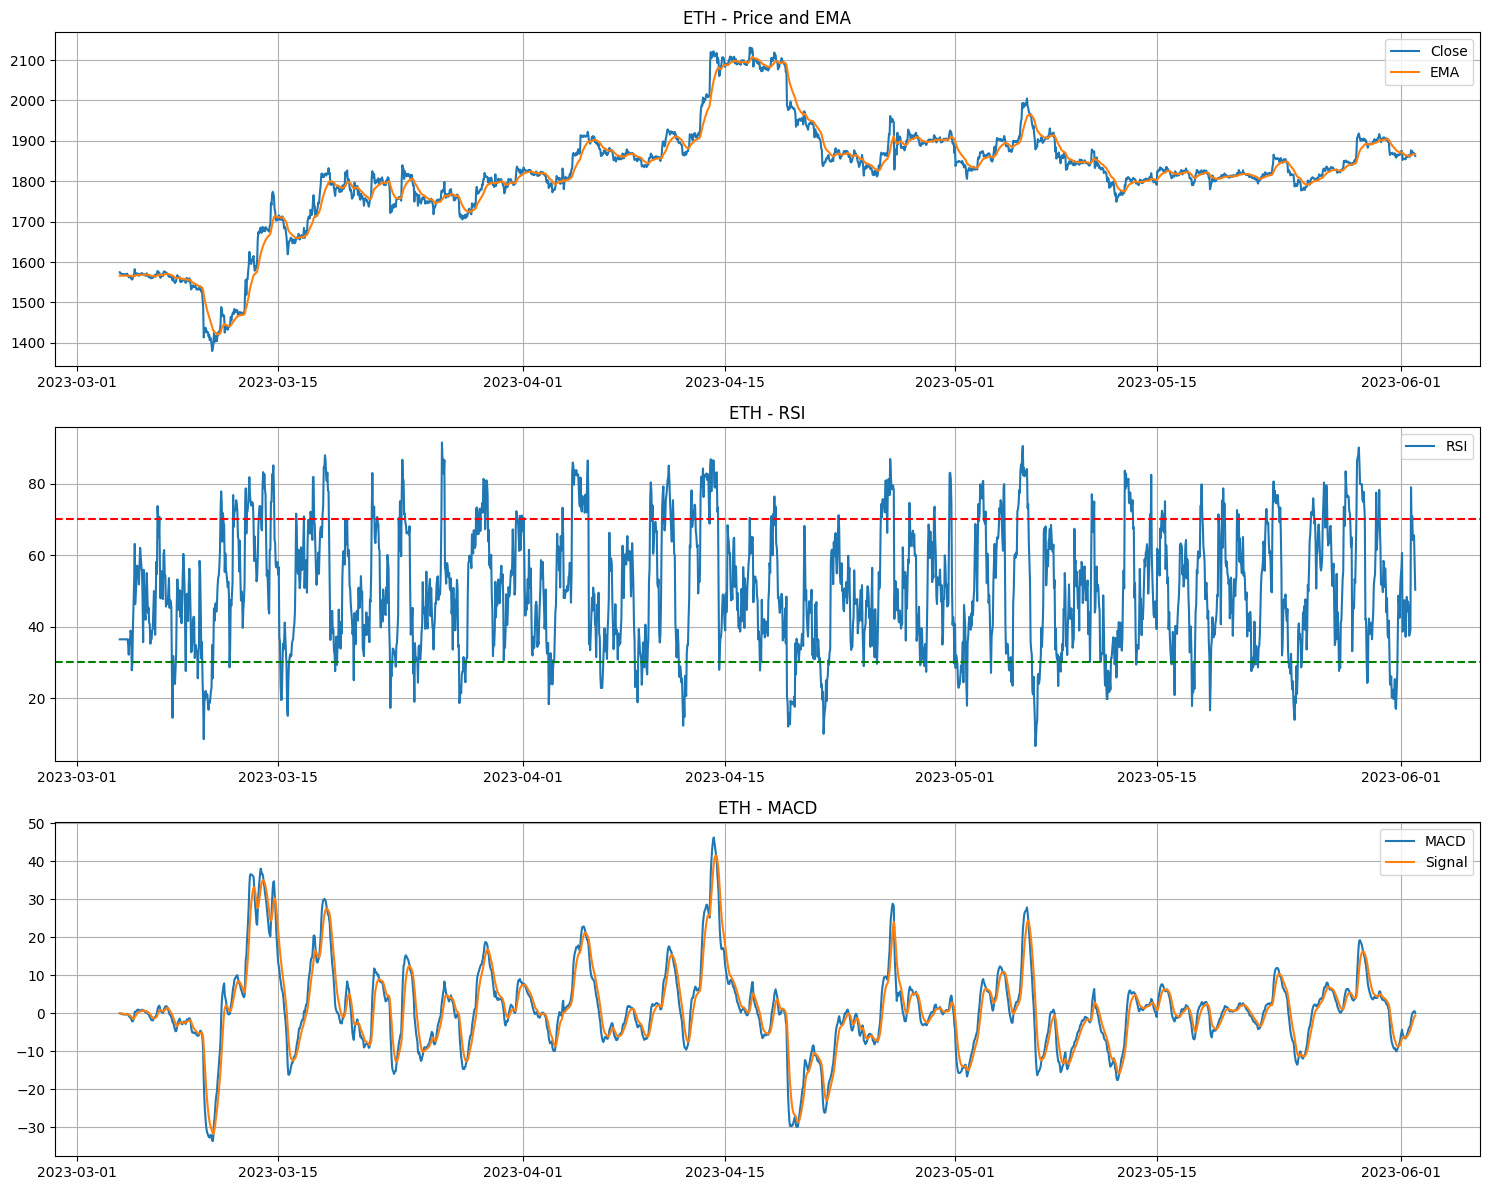

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

def fill_and_visualize_data(processed_data, all_coins):
    """
    Null ve Inf değerleri doldur ve görselleştir
    """
    filled_data = {}

    for data_type in ['train', 'val', 'test']:
        # Raw data (unscaled) kullan
        df = processed_data[data_type].copy()

        # Null değerleri doldur
        df = df.fillna(method='ffill').fillna(method='bfill')

        # Inf değerleri temizle
        df = df.replace([np.inf, -np.inf], np.nan).fillna(df.mean())

        filled_data[data_type] = df

        # Her coin için close price görselleştir
        plt.figure(figsize=(15, 10))
        for coin in all_coins:
            plt.plot(df[f'{coin}_close'], label=f'{coin.upper()} Close')

        plt.title(f'{data_type.upper()} Set - Close Prices After Filling')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Her coin için detaylı görselleştirme
        for coin in all_coins:
            plt.figure(figsize=(15, 12))

            # OHLC ve EMA
            plt.subplot(311)
            plt.plot(df[f'{coin}_close'], label='Close')
            plt.plot(df[f'{coin}_ema'], label='EMA')
            plt.title(f'{coin.upper()} - Price and EMA')
            plt.legend()
            plt.grid(True)

            # RSI
            plt.subplot(312)
            plt.plot(df[f'{coin}_rsi'], label='RSI')
            plt.axhline(y=70, color='r', linestyle='--')
            plt.axhline(y=30, color='g', linestyle='--')
            plt.title(f'{coin.upper()} - RSI')
            plt.legend()
            plt.grid(True)

            # MACD
            plt.subplot(313)
            plt.plot(df[f'{coin}_macd'], label='MACD')
            plt.plot(df[f'{coin}_macd_signal'], label='Signal')
            plt.title(f'{coin.upper()} - MACD')
            plt.legend()
            plt.grid(True)

            plt.tight_layout()
            plt.show()

    return filled_data

# Doldurulmuş verileri al
filled_data = fill_and_visualize_data(processed_data, all_coins)

In [ ]:
def check_data_issues(processed_data, all_coins):
   """
   Negatif, null ve inf değerleri kontrol eder
   """
   for data_type in ['train', 'val', 'test']:
       print(f"\n{'='*50}")
       print(f"{data_type.upper()} Set Analysis")
       print('='*50)

       df = processed_data[data_type]

       # Null değerler
       null_counts = df.isnull().sum()
       if null_counts.any():
           print("\nNull değer içeren kolonlar:")
           print(null_counts[null_counts > 0])

       # Negatif değerler
       neg_counts = df[df < 0].count()
       if neg_counts.any():
           print("\nNegatif değer içeren kolonlar:")
           print(neg_counts[neg_counts > 0])

       # Inf değerler
       inf_counts = df.isin([np.inf, -np.inf]).sum()
       if inf_counts.any():
           print("\nInf değer içeren kolonlar:")
           print(inf_counts[inf_counts > 0])

# Kontrol et
check_data_issues(processed_data, all_coins)


TRAIN Set Analysis

Null değer içeren kolonlar:
ltc_open    23
ltc_high    23
ltc_low     23
btc_sma     19
btc_ema     19
btc_rsi     13
ltc_sma     19
ltc_ema     19
ltc_rsi     13
xrp_sma     19
xrp_ema     19
xrp_rsi     13
eth_sma     19
eth_ema     19
eth_rsi     13
dtype: int64

Negatif değer içeren kolonlar:
btc_macd           7324
btc_macd_signal    7397
btc_macd_hist      7084
ltc_macd           6994
ltc_macd_signal    7005
ltc_macd_hist      6887
xrp_macd           7420
xrp_macd_signal    7451
xrp_macd_hist      6939
eth_macd           6867
eth_macd_signal    6951
eth_macd_hist      7019
dtype: int64

VAL Set Analysis

Null değer içeren kolonlar:
btc_sma    19
btc_ema    19
btc_rsi    13
ltc_sma    19
ltc_ema    19
ltc_rsi    13
xrp_sma    19
xrp_ema    19
xrp_rsi    13
eth_sma    19
eth_ema    19
eth_rsi    13
dtype: int64

Negatif değer içeren kolonlar:
btc_macd            920
btc_macd_signal     915
btc_macd_hist      1109
ltc_macd           1001
ltc_macd_signal     989


In [ ]:
def clean_data_for_vif(processed_data):
    cleaned_data = {}

    for data_type in ['train', 'val', 'test']:
        df = processed_data[data_type].copy()

        # MA'lar için rolling window başlangıç null değerlerini doldur
        for col in df.columns:
            if any(ind in col for ind in ['sma', 'ema']):
                df[col] = df[col].fillna(method='bfill').fillna(method='ffill')

        # RSI null değerlerini 50 ile doldur (nötr değer)
        rsi_cols = [col for col in df.columns if 'rsi' in col]
        df[rsi_cols] = df[rsi_cols].fillna(50)

        # LTC'nin başındaki null değerleri doldur
        if 'ltc_open' in df.columns:
            for col in ['ltc_open', 'ltc_high', 'ltc_low']:
                df[col] = df[col].fillna(method='bfill')

        cleaned_data[data_type] = df

    return cleaned_data

# Temizlenmiş veriyi kontrol et
cleaned_data = clean_data_for_vif(processed_data)
check_data_issues(cleaned_data, all_coins)


TRAIN Set Analysis


<ipython-input-19-8646ef7ba107>:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='bfill').fillna(method='ffill')
<ipython-input-19-8646ef7ba107>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='bfill')
<ipython-input-19-8646ef7ba107>:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='bfill').fillna(method='ffill')
<ipython-input-19-8646ef7ba107>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='bfill')
<ipython-input-19-8646ef7ba107>:10: FutureWarning: Series.fillna with 'method' is deprecated and will rais


Negatif değer içeren kolonlar:
btc_macd           7324
btc_macd_signal    7397
btc_macd_hist      7084
ltc_macd           6994
ltc_macd_signal    7005
ltc_macd_hist      6887
xrp_macd           7420
xrp_macd_signal    7451
xrp_macd_hist      6939
eth_macd           6867
eth_macd_signal    6951
eth_macd_hist      7019
dtype: int64

VAL Set Analysis

Negatif değer içeren kolonlar:
btc_macd            920
btc_macd_signal     915
btc_macd_hist      1109
ltc_macd           1001
ltc_macd_signal     989
ltc_macd_hist      1117
xrp_macd           1176
xrp_macd_signal    1178
xrp_macd_hist      1082
eth_macd            876
eth_macd_signal     876
eth_macd_hist      1143
dtype: int64

TEST Set Analysis

Negatif değer içeren kolonlar:
btc_macd           1040
btc_macd_signal    1016
btc_macd_hist      1083
ltc_macd           1010
ltc_macd_signal    1024
ltc_macd_hist      1053
xrp_macd           1050
xrp_macd_signal    1029
xrp_macd_hist      1097
eth_macd            996
eth_macd_signal     991
e

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid

def prepare_optimized_sequence_data(cleaned_data, all_coins, selected_features, sequence_length):
    """
    Seçilmiş feature'lar ve optimize edilmiş sequence length ile veri hazırlar
    """
    X_dict = {}
    y_dict = {}
    scalers = {}

    # Her coin için ayrı scaler oluştur (sadece close price için)
    for coin in all_coins:
        scalers[coin] = MinMaxScaler()
        close_prices = cleaned_data['train'][f'{coin}_close'].values.reshape(-1, 1)
        scalers[coin].fit(close_prices)

    for data_type in ['train', 'val', 'test']:
        data = cleaned_data[data_type].copy()

        # Seçilmiş feature'ları kullanarak yeni DataFrame oluştur
        selected_columns = []
        for coin in all_coins:
            selected_columns.extend(selected_features[coin])

        # Scaled data oluştur
        scaled_data = pd.DataFrame()
        for column in selected_columns:
            values = data[column].values.reshape(-1, 1)

            if '_volume' in column:
                # Volume için log transform
                values = np.log1p(values)

            scaled_data[column] = MinMaxScaler().fit_transform(values).flatten()

        sequences = []
        targets = []

        for i in range(len(scaled_data) - sequence_length):
            # Input sequence
            sequence = scaled_data.iloc[i:(i + sequence_length)].values
            sequences.append(sequence)

            # Target (scaled close prices)
            target = [scaled_data[f'{coin}_close'].iloc[i + sequence_length] for coin in all_coins]
            targets.append(target)

        X_dict[data_type] = np.array(sequences)
        y_dict[data_type] = np.array(targets)

        print(f"{data_type} set shapes:")
        print(f"X_{data_type}: {X_dict[data_type].shape}")
        print(f"y_{data_type}: {y_dict[data_type].shape}")

    return X_dict, y_dict, scalers

def create_lstm_model(hp, input_shape):
    model = Sequential([
        LSTM(units=hp['units'],
             input_shape=input_shape),
        Dropout(hp['dropout']),
        Dense(4)  # 4 coin için 4 çıkış
    ])

    model.compile(optimizer=Adam(learning_rate=hp['learning_rate']),
                 loss='mse',
                 metrics=['mae'])

    return model

def hyperparameter_search(X_data, y_data):
    input_shape = (X_data['train'].shape[1], X_data['train'].shape[2])

    # Daha az kombinasyonla başlayalım
    param_grid = {
        'units': [64, 128],
        'dropout': [0.2, 0.3],
        'learning_rate': [0.001, 0.0001],
        'batch_size': [32, 64],
        'epochs': [100]  # epoch sayısını artırdım
    }

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,  # patience 20 yapıldı
        restore_best_weights=True,
        verbose=1
    )

    results = []

    for hp in ParameterGrid(param_grid):
        print(f"\nTesting parameters: {hp}")
        model = create_lstm_model(hp, input_shape)

        history = model.fit(
            X_data['train'], y_data['train'],
            validation_data=(X_data['val'], y_data['val']),
            epochs=hp['epochs'],
            batch_size=hp['batch_size'],
            callbacks=[early_stopping],
            verbose=1
        )

        val_loss = min(history.history['val_loss'])
        results.append({
            'hyperparameters': hp,
            'val_loss': val_loss,
            'best_epoch': np.argmin(history.history['val_loss']) + 1,
            'history': history.history
        })

        print(f"Validation Loss: {val_loss:.6f}")
        tf.keras.backend.clear_session()

    return results

# Veriyi hazırla ve grid search'ü başlat
X_data, y_data, scalers = prepare_optimized_sequence_data(
    cleaned_data=cleaned_data,
    all_coins=all_coins,
    selected_features=selected_features,
    sequence_length=optimal_seq_length
)

search_results = hyperparameter_search(X_data, y_data)

# En iyi sonuçları görüntüle
print("\nTop 5 Best Configurations:")
for i, result in enumerate(search_results[:5], 1):
    print(f"\n{i}. Best Configuration:")
    print(f"Parameters: {result['hyperparameters']}")
    print(f"Validation Loss: {result['val_loss']:.6f}")
    print(f"Best Epoch: {result['best_epoch']}")

train set shapes:
X_train: (13964, 4, 20)
y_train: (13964, 4)
val set shapes:
X_val: (2156, 4, 20)
y_val: (2156, 4)
test set shapes:
X_test: (2156, 4, 20)
y_test: (2156, 4)

Testing parameters: {'batch_size': 32, 'dropout': 0.2, 'epochs': 100, 'learning_rate': 0.001, 'units': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0189 - mae: 0.0864 - val_loss: 0.0046 - val_mae: 0.0522
Epoch 2/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0021 - mae: 0.0340 - val_loss: 0.0017 - val_mae: 0.0337
Epoch 3/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0015 - mae: 0.0278 - val_loss: 0.0015 - val_mae: 0.0310
Epoch 4/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0012 - mae: 0.0241 - val_loss: 0.0014 - val_mae: 0.0299
Epoch 5/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0010 - mae: 0.0225 - val_loss: 0.0016 - val_mae: 0.0334
Epoch 6/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 8.4849e-04 - mae: 0.0206 - val_loss: 0.0015 - val_mae: 0.0311
Epoch 7/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7.7333e-04 - mae: 0.0196 - val_loss: 0.0013 - val_mae: 0.0289
Epoch 8/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 6.4394e-04 - mae: 0.0181 - val_loss: 0.0016 - val_mae: 0.0337
Epoch 9/100
437/437 ━━━━━━━━━━━━━━━━

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0163 - mae: 0.0778 - val_loss: 0.0021 - val_mae: 0.0348
Epoch 2/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0013 - mae: 0.0269 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 3/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0010 - mae: 0.0229 - val_loss: 7.8597e-04 - val_mae: 0.0202
Epoch 4/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 7.9768e-04 - mae: 0.0201 - val_loss: 0.0013 - val_mae: 0.0294
Epoch 5/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 7.1425e-04 - mae: 0.0188 - val_loss: 9.5194e-04 - val_mae: 0.0235
Epoch 6/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 5.9169e-04 - mae: 0.0173 - val_loss: 0.0017 - val_mae: 0.0347
Epoch 7/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.6459e-04 - mae: 0.0170 - val_loss: 8.0413e-04 - val_mae: 0.0213
Epoch 8/100
437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4.5920e-04 - mae: 0.0151 - val_loss: 0.0010 - val_mae: 0.0255
Epoch 9/100
437/437 ━━━━━━━━

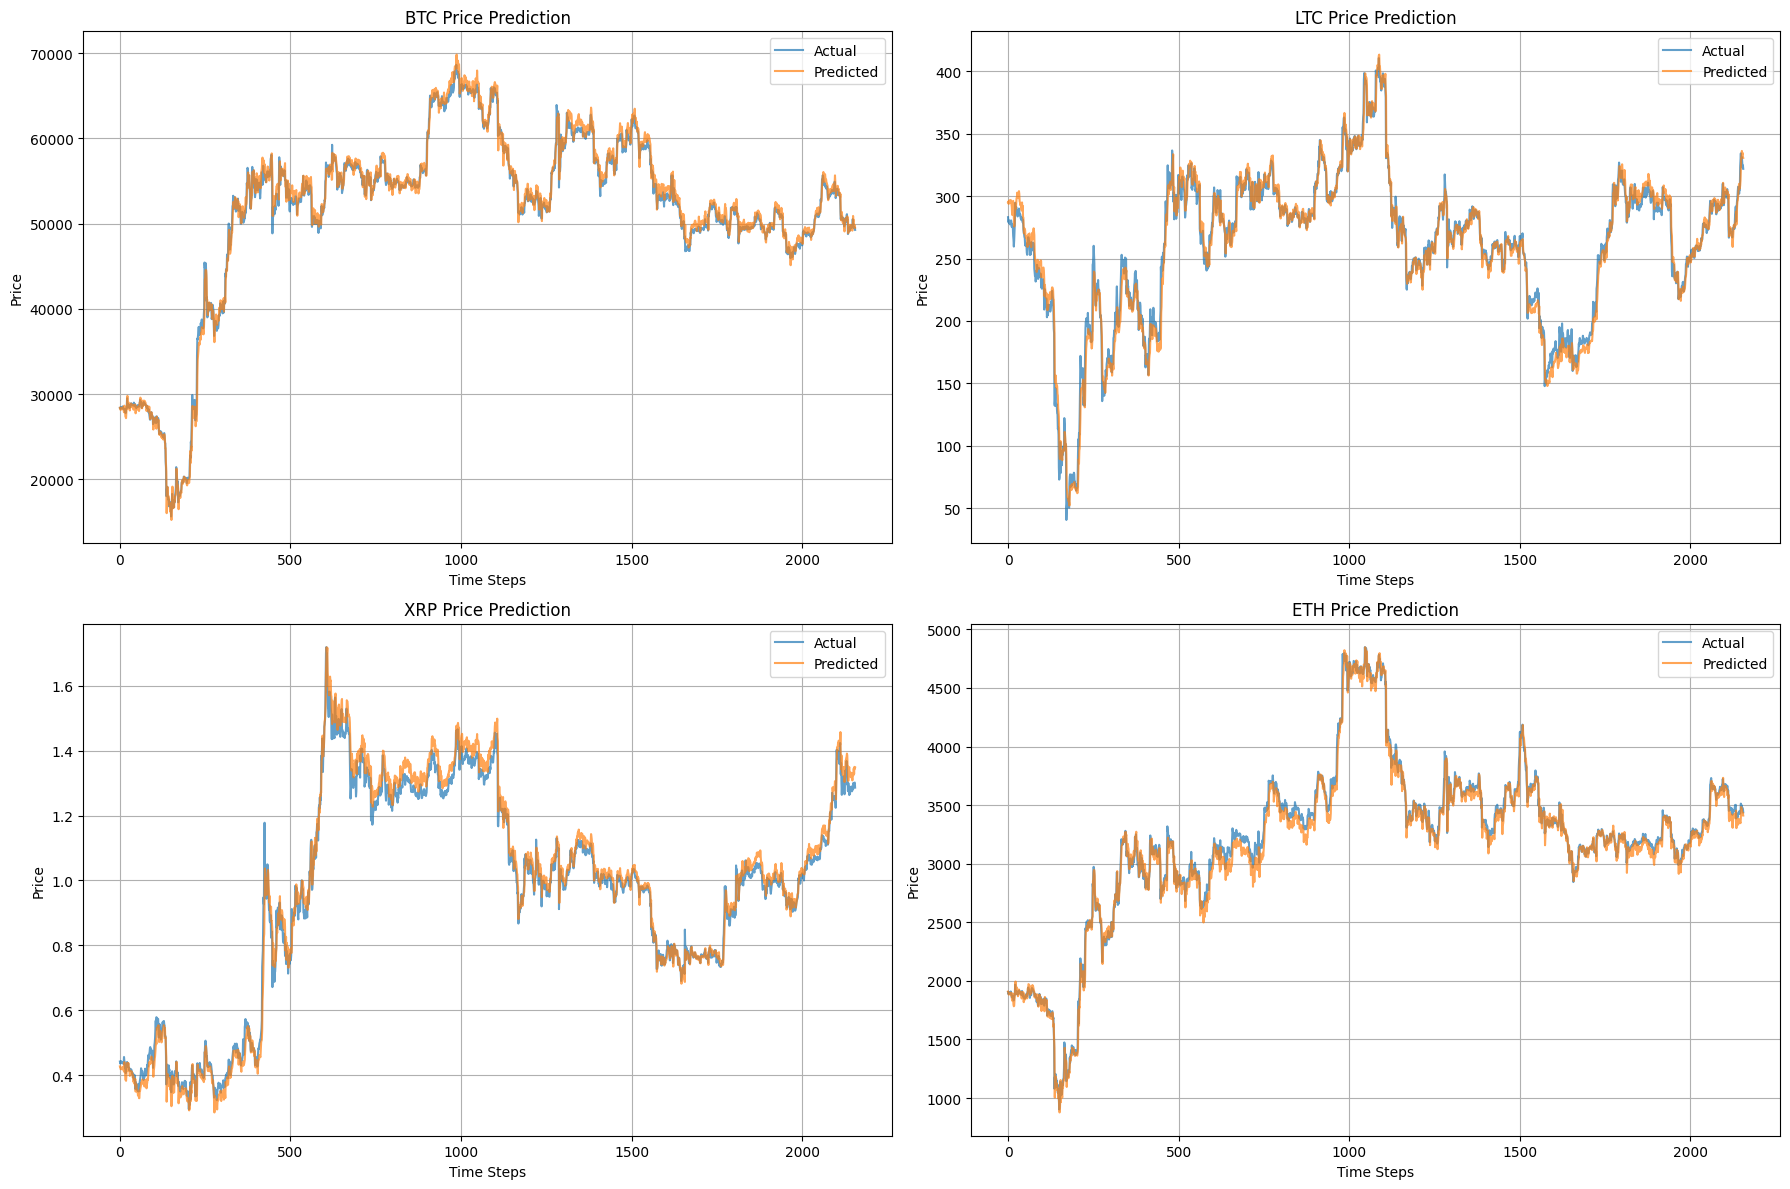

In [22]:
# En iyi hiperparametrelerle final modeli eğitme ve test etme
best_hp = {
    'units': 128,
    'dropout': 0.2,
    'learning_rate': 0.001,
    'batch_size': 32,
    'epochs': 100
}

# Modeli oluştur ve eğit
final_model = create_lstm_model(best_hp, (X_data['train'].shape[1], X_data['train'].shape[2]))
history = final_model.fit(
    X_data['train'], y_data['train'],
    validation_data=(X_data['val'], y_data['val']),
    epochs=best_hp['epochs'],
    batch_size=best_hp['batch_size'],
    callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)],
    verbose=1
)

# Test seti üzerinde değerlendirme
test_loss, test_mae = final_model.evaluate(X_data['test'], y_data['test'], verbose=0)
print(f"\nTest MSE: {test_loss:.6f}, Test MAE: {test_mae:.6f}")

# Tahminleri yap ve inverse transform
y_pred = final_model.predict(X_data['test'])

# Gerçek ve tahminleri inverse scale etme
def inverse_scale_predictions(y_true_scaled, y_pred_scaled, scalers, coins):
    y_true_df = pd.DataFrame(y_true_scaled, columns=[f'{coin}_close' for coin in coins])
    y_pred_df = pd.DataFrame(y_pred_scaled, columns=[f'{coin}_close' for coin in coins])

    for coin in coins:
        # Gerçek değerleri inverse transform
        y_true_df[f'{coin}_close'] = scalers[coin].inverse_transform(
            y_true_df[f'{coin}_close'].values.reshape(-1, 1)).flatten()

        # Tahminleri inverse transform
        y_pred_df[f'{coin}_close'] = scalers[coin].inverse_transform(
            y_pred_df[f'{coin}_close'].values.reshape(-1, 1)).flatten()

    return y_true_df, y_pred_df

# Inverse scaling uygula
y_true, y_pred = inverse_scale_predictions(y_data['test'], y_pred, scalers, all_coins)

# Metrikleri hesaplama fonksiyonu
def calculate_metrics(y_true, y_pred, coins):
    metrics = {}
    for coin in coins:
        actual = y_true[f'{coin}_close']
        pred = y_pred[f'{coin}_close']

        # MSE ve RMSE
        mse = np.mean((actual - pred)**2)
        rmse = np.sqrt(mse)

        # MAE
        mae = np.mean(np.abs(actual - pred))

        # MAPE (Yüzde olarak)
        mape = np.mean(np.abs((actual - pred)/actual)) * 100

        metrics[coin] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE (%)': mape
        }
    return metrics

# Metrikleri hesapla ve göster
metrics = calculate_metrics(y_true, y_pred, all_coins)
metrics_df = pd.DataFrame(metrics).T
print("\nModel Performance Metrics:")
print(metrics_df)

# Gerçek vs Tahmin görselleştirme
plt.figure(figsize=(18, 12))
for i, coin in enumerate(all_coins, 1):
    plt.subplot(2, 2, i)
    plt.plot(y_true[f'{coin}_close'].values, label='Actual', alpha=0.7)
    plt.plot(y_pred[f'{coin}_close'].values, label='Predicted', alpha=0.7)
    plt.title(f'{coin.upper()} Price Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()